# SWB Regression Pipeline - Beta Power x RPE OR PROFIT

Created: 07/30/24 \
Updated: 09/30/2024 \
*ran with 1 sec regression dfs from 09/24/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2



In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



09302024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *



In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

# Load beta power data 

In [7]:
epoch_len = '1sec'
band = 'beta'

In [8]:
beta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
beta_df.subj_id.unique()



array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
beta_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'bdi_thresh', 'Round', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'ChoicePos', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'epoch', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type', 'cf',
       'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset',
       'reref_ch_names', 'band_pow', 'roi', 'hemi', 'unique_reref_ch'],
      dtype='object')

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()



roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois

['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)



# Electrode-wise Regressions + Permutations

In [33]:
elec_col    = 'unique_reref_ch'
main_var    = 'rpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe'
n_permutations = 1000


In [15]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1675.60it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1675.22it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1724.67it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1719.17it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1755.15it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1631.01it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3650.18it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3658.08it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3662.13it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3687.95it/s]


In [16]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe']

In [17]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.064039   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.059430   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.046862   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.006999   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.039931   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.029363   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.060428   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.007966   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                     0.016019   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.105467   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.125957                   0.037634   
1                                  -0.081313                   0.017947   
2                                  -0.081290                   0.023655   
3                                  -0.020485                   0.060999   
4                                  -0.043619                  -0.010247   
...                                      ...                        ...   
1183                               -0.003817                   0.014478   
1184                                0.002060                   0.000685   
1185                               -0.126183                  -0.030164   
1186                               -0.050555                   0.033034   
1187                               -0.155186                  -0.027381   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
0                  0.074256                -0.024507   
1                  0.084334                 0.003049   
2                  0.088862                -0.009856   
3                 -0.028676                -0.006835   
4                  0.011890                 0.010471   
...                     ...                      ...   
1183               0.042918                 0.027529   
1184               0.048777                 0.061443   
1185               0.043664                -0.059219   
1186               0.023931                -0.001723   
1187               0.121051                 0.041447   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.001850  ...              0.039524   
1                               0.000047  ...              0.037369   
2                               0.000587  ...              0.036832   
3                              -0.000253  ...              0.038082   
4                              -0.001206  ...              0.038683   
...                                  ...  ...                   ...   
1183                            0.001839  ...              0.041733   
1184                           -0.001662  ...              0.051624   
1185                           -0.002336  ...              0.044378   
1186                           -0.001961  ...              0.040258   
1187                           -0.000904  ...              0.056675   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.039376           2.758024                     -2.765346   
1             0.036114           1.930814                     -1.935565   
2             0.035433           2.039747                     -2.045212   
3             0.035542           0.480847                     -0.488569   
4             0.037954           0.967212                     -0.967433   
...                ...                ...                           ...   
1183          0.034909           0.103894                     -0.137249   
1184          0.043829          -0.045026      

In [18]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_rpe',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TrialEV', 'Permuted_Mean_rpe', 'Permuted_Std_Intercept',
       'Permuted_Std_GambleChoice[T.safe]', 'Permuted_Std_TrialEV',
       'Permuted_Std_rpe', 'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]',
       'Z_Score_TrialEV', 'Z_Score_rpe', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TrialEV', 'P_Value_rpe'],
      dtype='object')

### Save results as pickle file

In [19]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_{main_var}_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [20]:
# save_path = f'{save_dir}/{band}/'
# os.makedirs(save_path, exist_ok=True)

# fname = f'{save_path}{band}_perm_regression_results_{epoch_len}.pkl'
# pickle.dump(results, open(fname,"wb"))


In [21]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
1     MS002_lacas2-lacas3   MS002    acc   14                     0.059430   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.046862   
30    MS002_lloif7-lloif8   MS002  vlpfc   14                     0.174969   
33    MS002_lmoif8-lmoif9   MS002  vlpfc   14                     0.146778   
39    MS002_lpips2-lpips3   MS002   pins   14                     0.004978   
...                   ...     ...    ...  ...                          ...   
1147      DA037_rof3-rof4   DA037    ofc    4                    -0.165508   
1169      DA039_rfp4-rfp5   DA039    ofc   22                    -0.080006   
1179      DA039_rof8-rof9   DA039  dlpfc   22                     0.047169   
1181    DA039_rof10-rof11   DA039  dlpfc   22                     0.052487   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.105467   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
1                                  -0.081313                   0.017947   
2                                  -0.081290                   0.023655   
30                                 -0.213863                  -0.070331   
33                                 -0.239216                  -0.052085   
39                                 -0.042432                  -0.044908   
...                                      ...                        ...   
1147                                0.056330                   0.017127   
1169                                0.005924                   0.005990   
1179                               -0.097441                   0.013907   
1181                               -0.104429                   0.023929   
1187                               -0.155186                  -0.027381   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
1                  0.084334                 0.003049   
2                  0.088862                -0.009856   
30                 0.109711                 0.027828   
33                 0.129245                -0.017702   
39                -0.072067                -0.024936   
...                     ...                      ...   
1147               0.063648                -0.152677   
1169               0.010557                -0.077452   
1179               0.075254                 0.007702   
1181               0.088185                 0.011631   
1187               0.121051                 0.041447   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
1                               0.000047  ...              0.037369   
2                               0.000587  ...              0.036832   
30                             -0.002116  ...              0.048893   
33                             -0.002398  ...              0.050187   
39                              0.000446  ...              0.036106   
...                                  ...  ...                   ...   
1147                           -0.001020  ...              0.024187   
1169                            0.000079  ...              0.006001   
1179                            0.001738  ...              0.044719   
1181                           -0.000730  ...              0.042934   
1187                           -0.000904  ...              0.056675   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
1             0.036114           1.930814                     -1.935565   
2             0.035433           2.039747                     -2.045212   
30            0.046685           3.959095                     -3.958662   
33            0.047919           4.389032                     -4.390283   
39            0.036180           1.024942                     -1.020514   
...                ...                ...                           ...   
1147          0.021626          -1.997165                      2.103397   
1169          0.005152          -0.956443      

In [22]:
sig_data.roi.value_counts()



roi
acc      31
ofc      21
dmpfc    20
ains     15
vlpfc    14
hpc       9
pins      7
dlpfc     7
amy       6
Name: count, dtype: int64

In [23]:
sig_data.roi.unique()



array(['acc', 'vlpfc', 'pins', 'dmpfc', 'ains', 'hpc', 'ofc', 'amy',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [24]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.064039   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.059430   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.046862   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.006999   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.039931   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.125957                   0.037634   
1                               -0.081313                   0.017947   
2                               -0.081290                   0.023655   
3                               -0.020485                   0.060999   
4                               -0.043619                  -0.010247   

   Original_Estimate_rpe  Permuted_Mean_Intercept  \
0               0.074256                -0.024507   
1               0.084334                 0.003049   
2               0.088862                -0.009856   
3              -0.028676                -0.006835   
4               0.011890                 0.010471   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                            0.001850  ...           2.758024   
1                            0.000047  ...           1.930814   
2                            0.000587  ...           2.039747   
3                           -0.000253  ...           0.480847   
4                           -0.001206  ...           0.967212   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_rpe  \
0                     -2.765346         0.923537     1.860853   
1                     -1.935565         0.458079     2.326727   
2                     -2.045212         0.635307     2.505998   
3                     -0.488569         1.614522    -0.727397   
4                     -0.967433        -0.247611     0.286875   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.005815                      0.005686         0.355727   
1           0.053506                      0.052921         0.646896   
2           0.041376                      0.040834         0.525228   
3           0.630625                      0.625147         0.106414   
4           0.333438                      0.333328         0.804436   

   P_Value_rpe  rpe_sig  bdi_split  
0     0.062765        0          0  
1     0.019980        1          0  
2     0.012211        1          0  
3     0.466983        0          0  
4     0.774208        0          0  

[5 rows x 26 columns]

In [25]:
rpe_var = 'Z_Score_rpe'

In [26]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [27]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc    0.396720
vlpfc    0.531059
dmpfc    0.124436
ofc      0.135740
ains     0.993101
pins     0.457030
acc      0.396237
amy      0.136661
hpc      0.052259
Name: Z_Score_rpe, dtype: float64

In [28]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [29]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     31  0.160622              5    4.339810  2.303718e-05   
1  dmpfc      225     20  0.088889              6    1.783204  7.590716e-02   
2    amy      113      6  0.053097              1    1.261519  2.097431e-01   
3   ains       71     15  0.211268              1    6.385841  1.612360e-08   
4  vlpfc       82     14  0.170732              1    3.543675  6.583018e-04   
5    hpc      135      9  0.066667              0    0.570494  5.692983e-01   
6    ofc      202     21  0.103960              7    1.683669  9.379805e-02   
7   pins       60      7  0.116667              0    2.927204  4.851610e-03   
8  dlpfc      107      7  0.065421              2    4.476245  1.919894e-05   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.118707            1.0    0.160622      0.0000  
1      0.059687            1.0    0.088889      0.0097  
2      0.023374            1.0    0.053097      0.4994  
3      0.134975            1.0    0.211268      0.0000  
4      0.106274            1.0    0.170732      0.0001  
5      0.035217            1.0    0.066667      0.2349  
6      0.070726            1.0    0.103960      0.0013  
7      0.056055            1.0    0.116667      0.0297  
8      0.031104            1.0    0.065421      0.2879

In [30]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     31  0.160622              5    4.339810  2.303718e-05   
1  dmpfc      225     20  0.088889              6    1.783204  7.590716e-02   
3   ains       71     15  0.211268              1    6.385841  1.612360e-08   
4  vlpfc       82     14  0.170732              1    3.543675  6.583018e-04   
6    ofc      202     21  0.103960              7    1.683669  9.379805e-02   
7   pins       60      7  0.116667              0    2.927204  4.851610e-03   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.118707            1.0    0.160622      0.0000  
1      0.059687            1.0    0.088889      0.0097  
3      0.134975            1.0    0.211268      0.0000  
4      0.106274            1.0    0.170732      0.0001  
6      0.070726            1.0    0.103960      0.0013  
7      0.056055            1.0    0.116667      0.0297

# Plot Results

In [34]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_{main_var}_coeff_barplot.pdf'

ylabel = fr'${band}_{{zpow}} \sim RPE$'


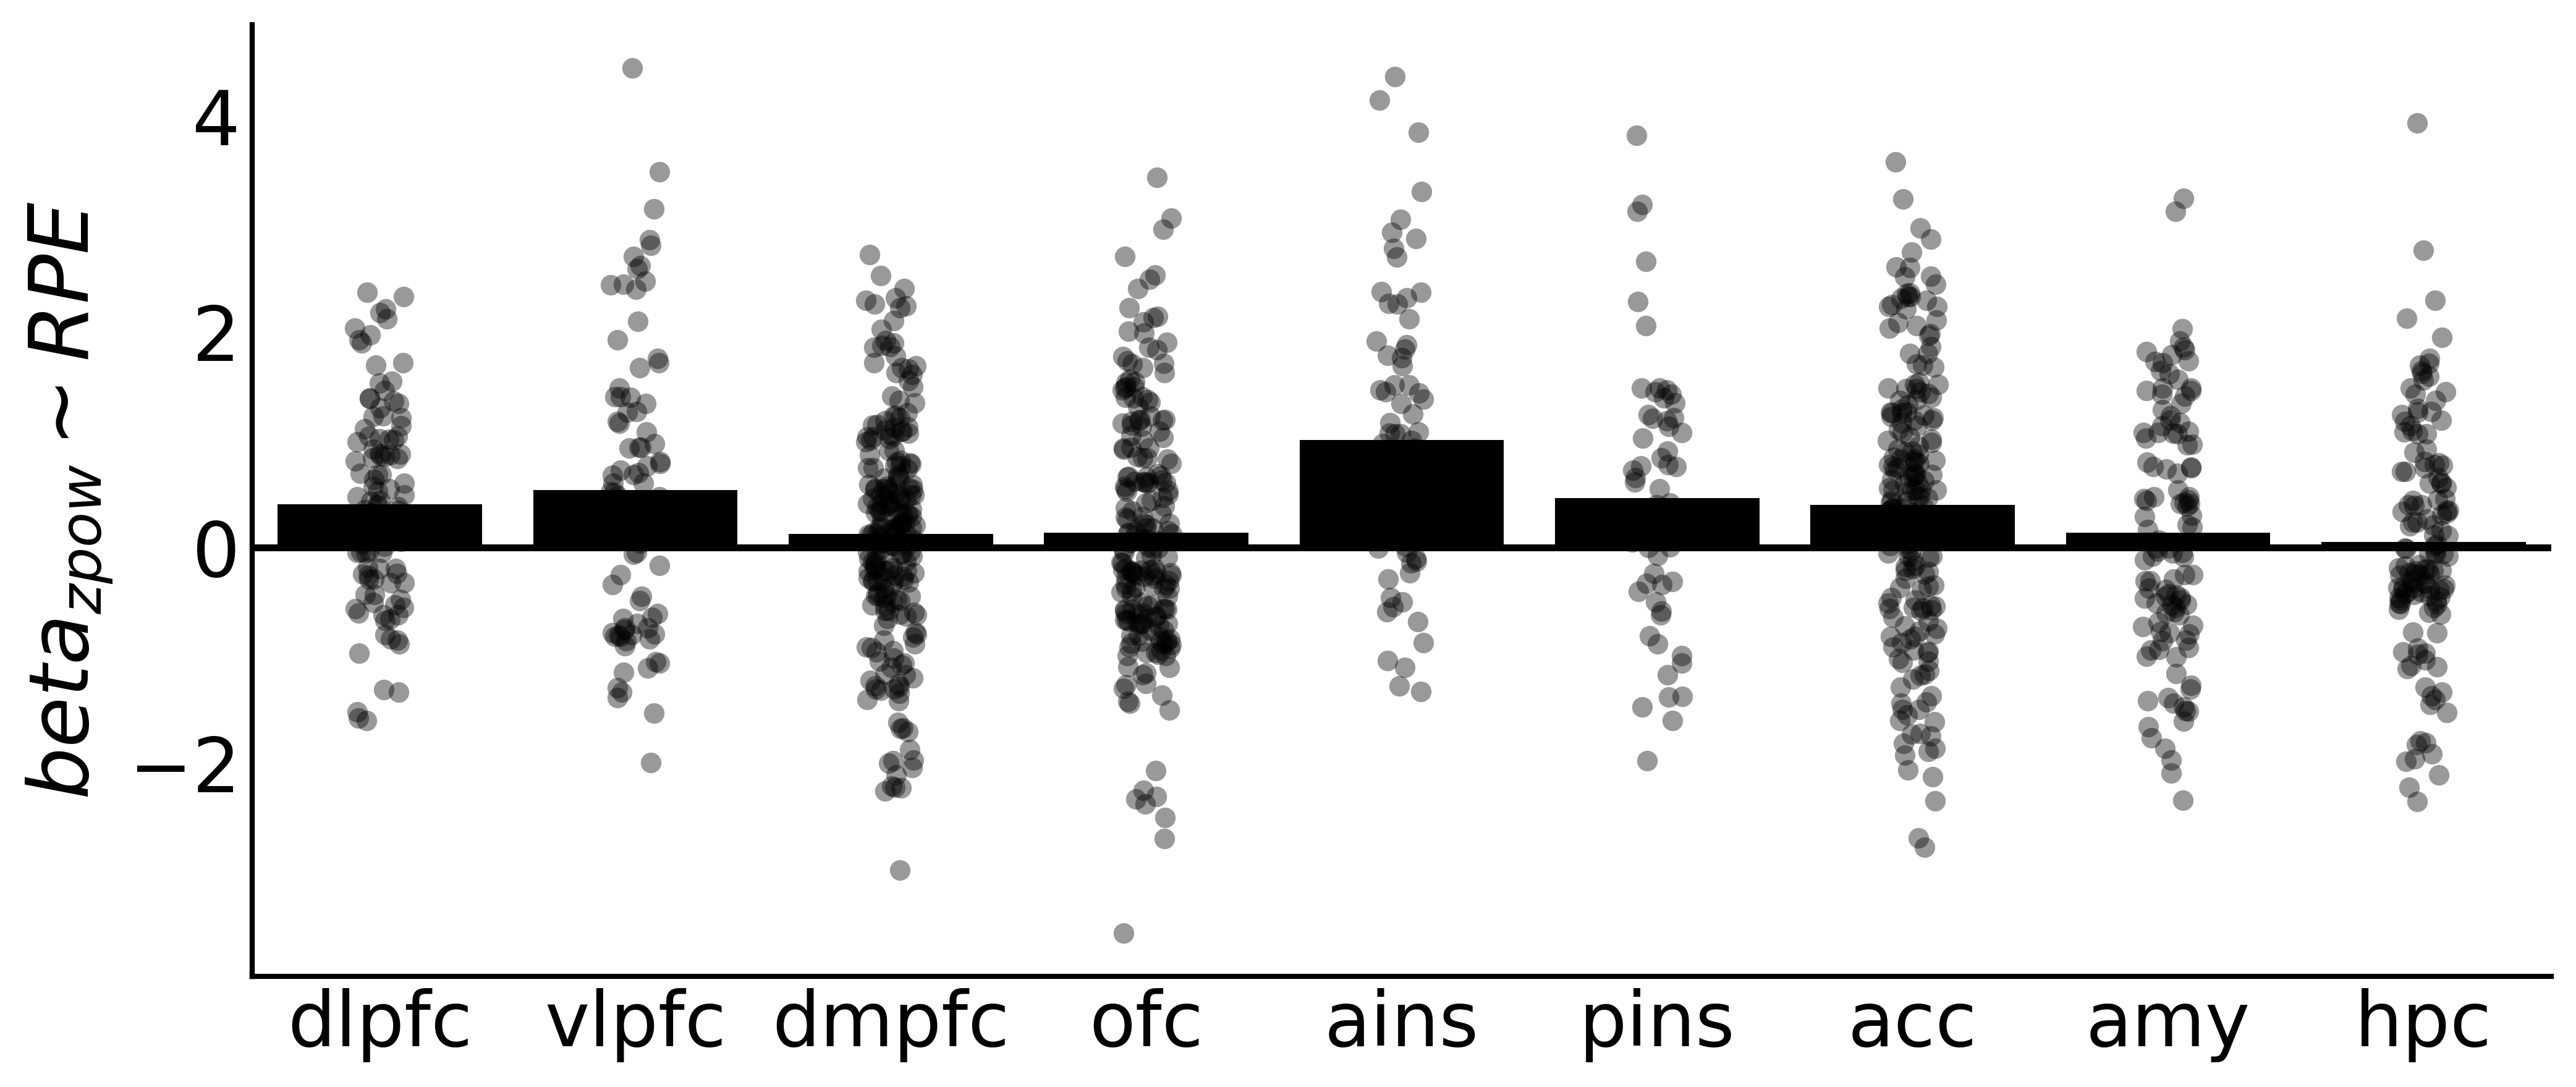

In [35]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

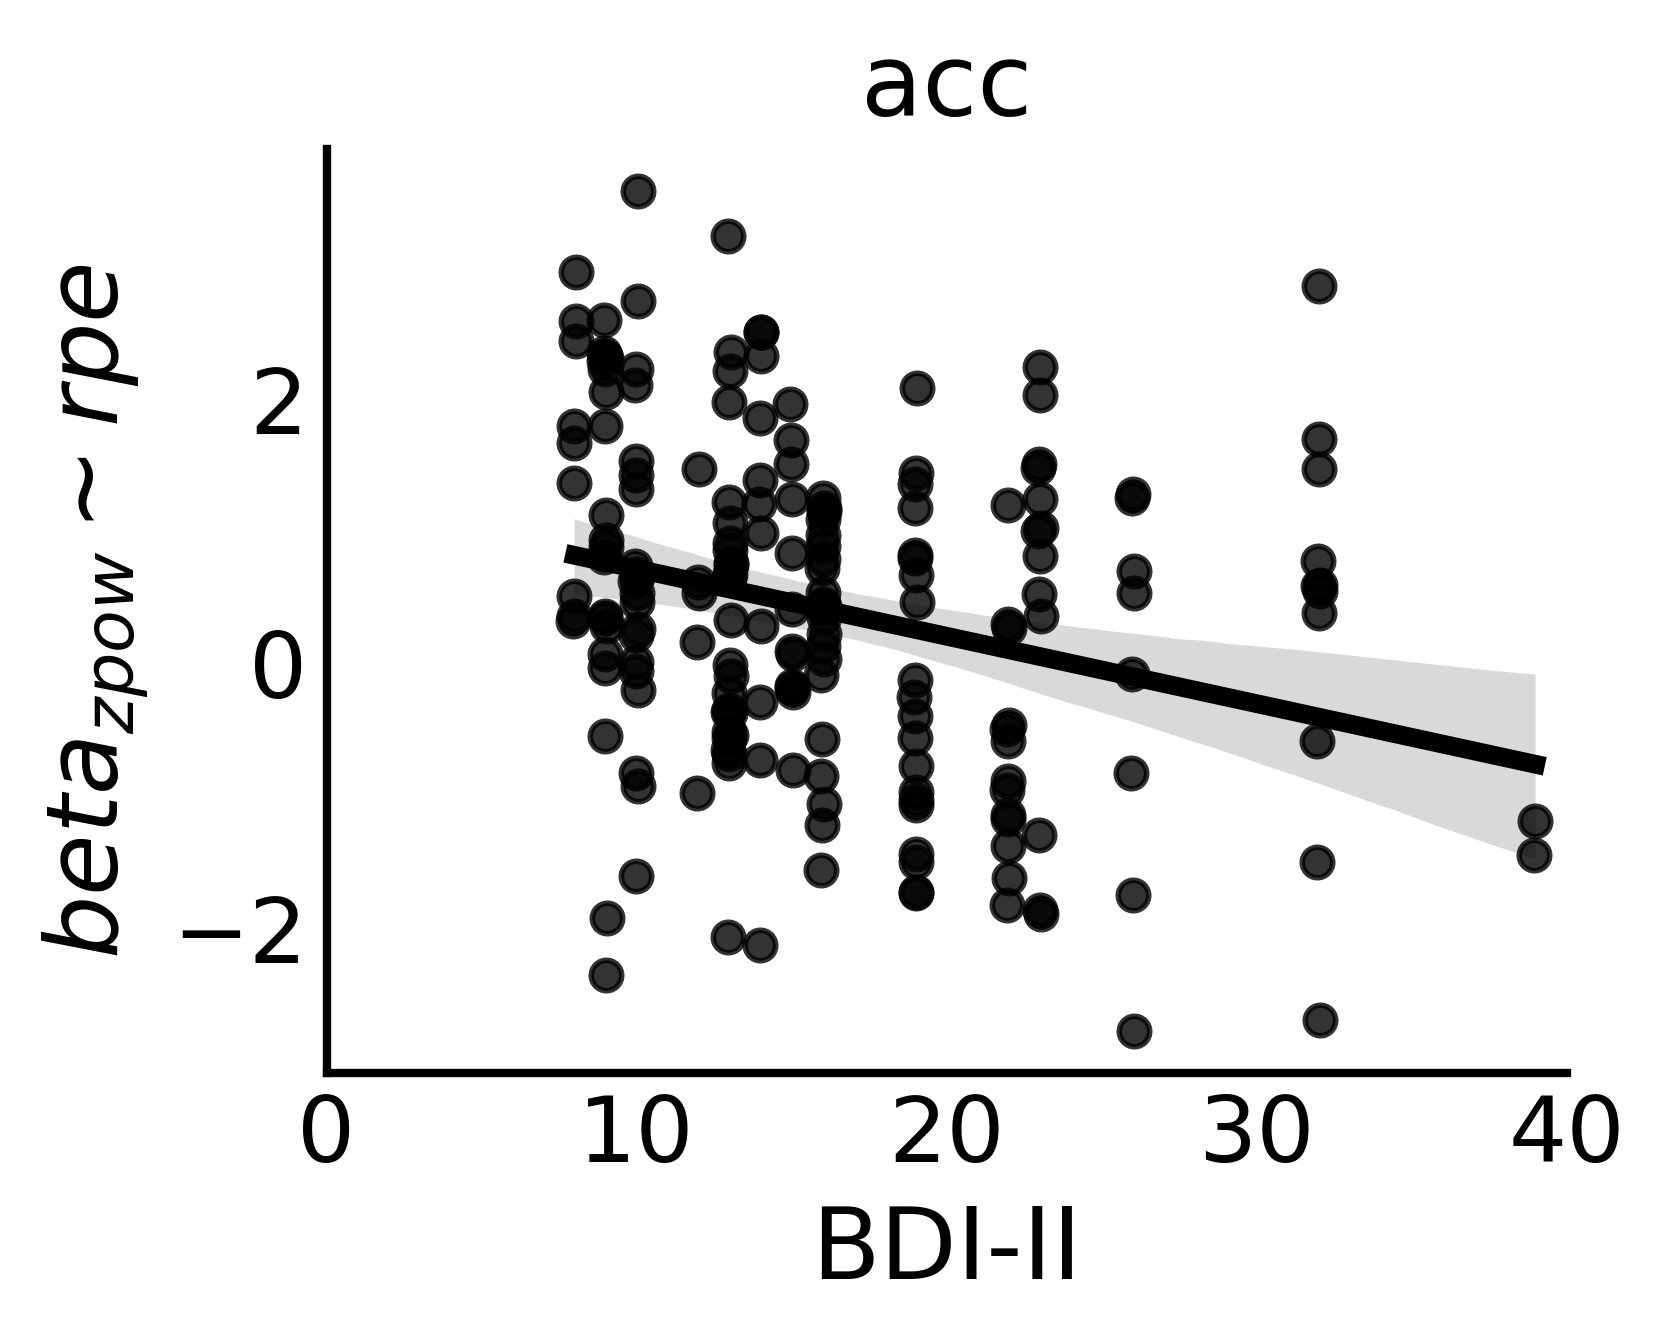

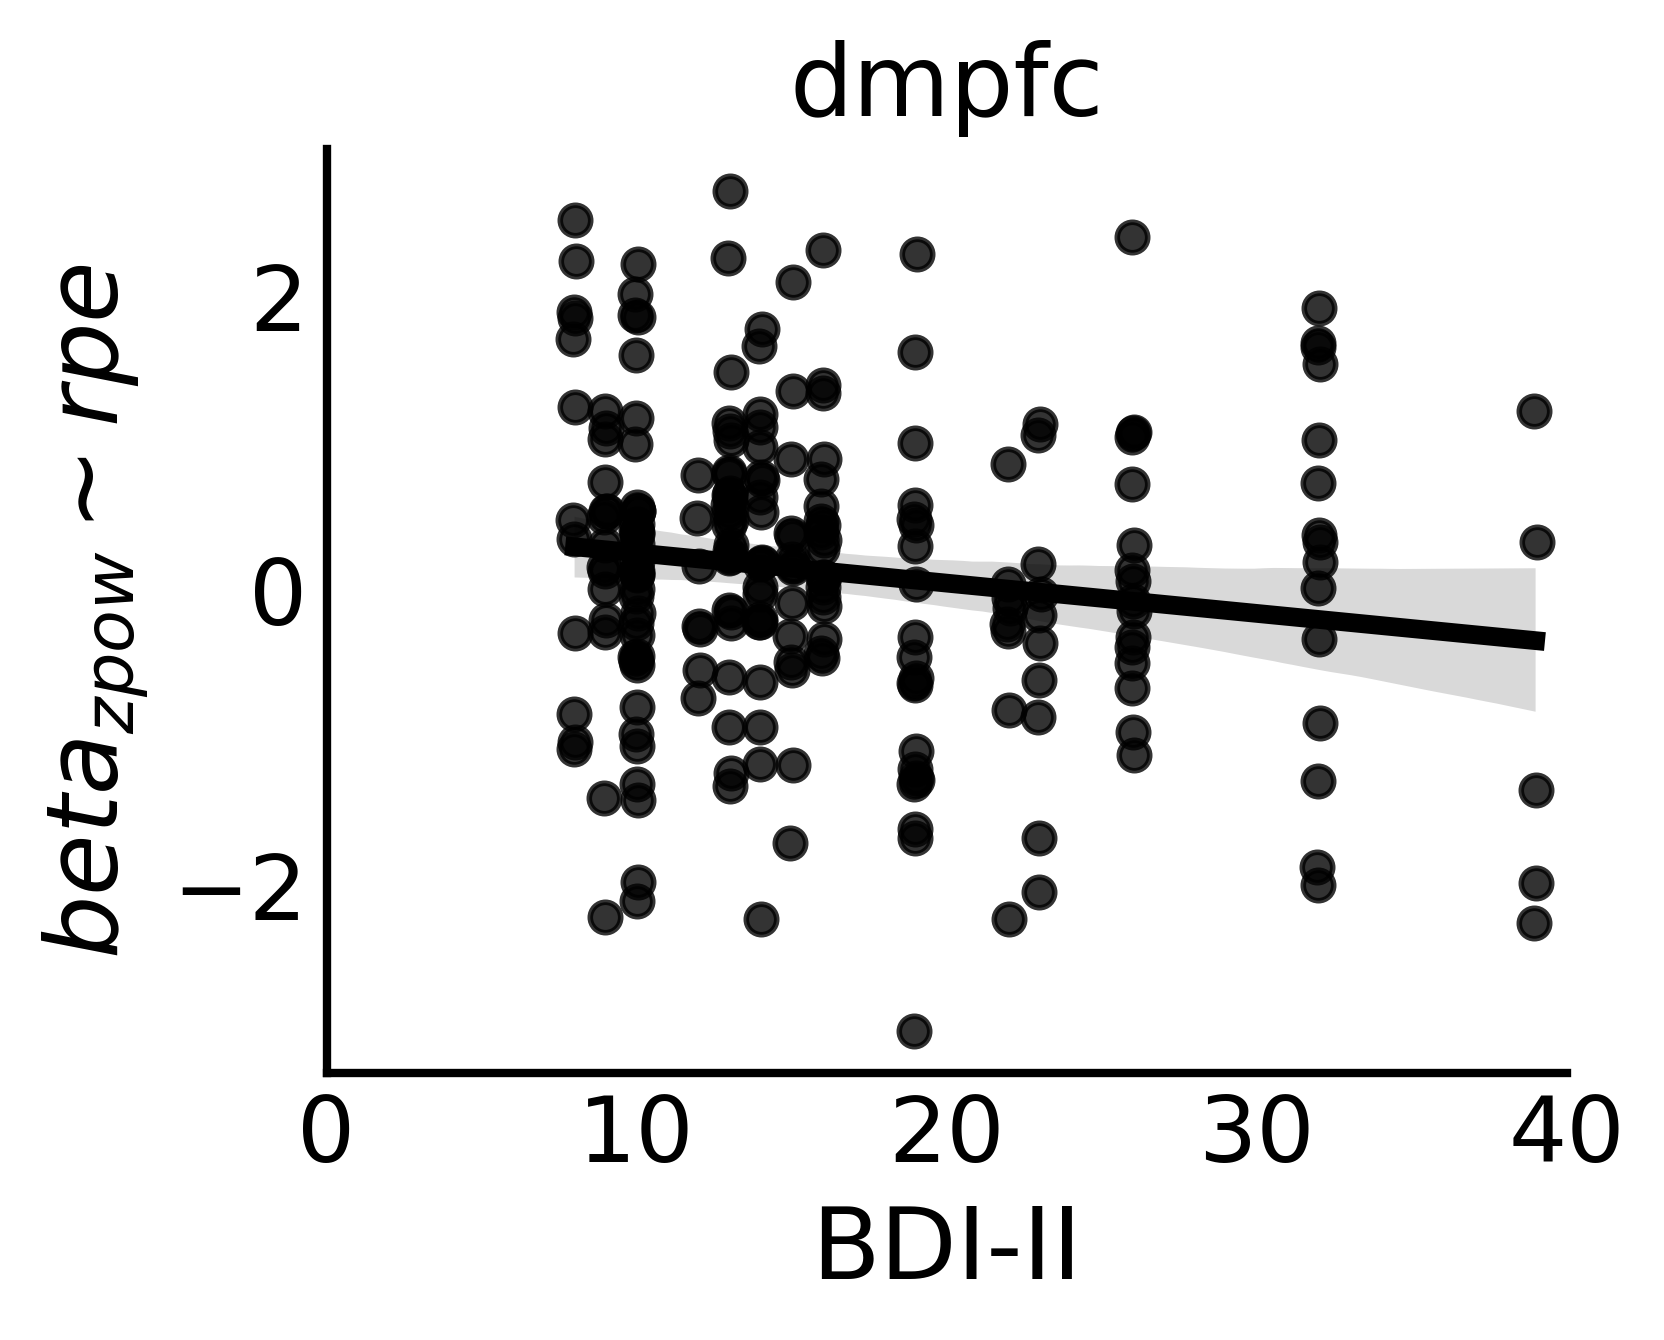

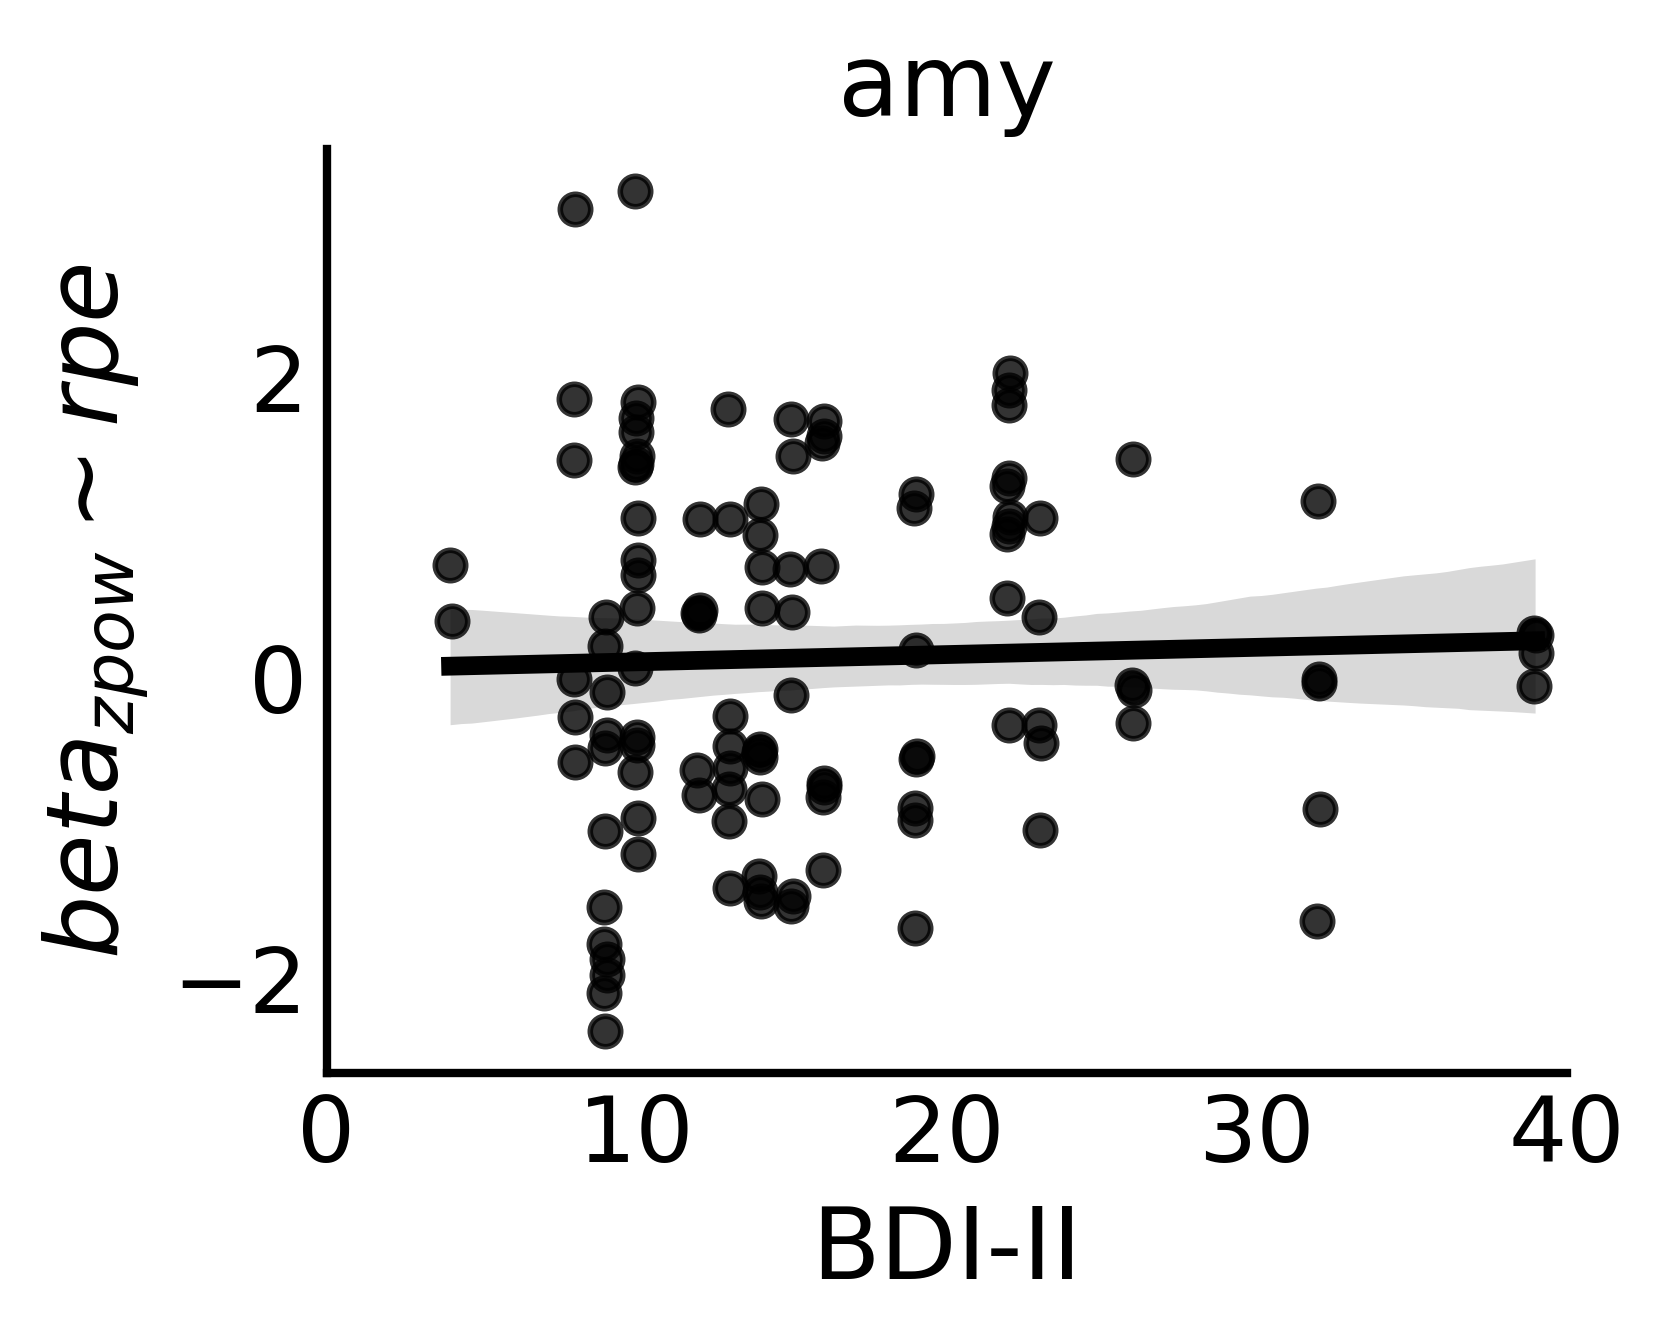

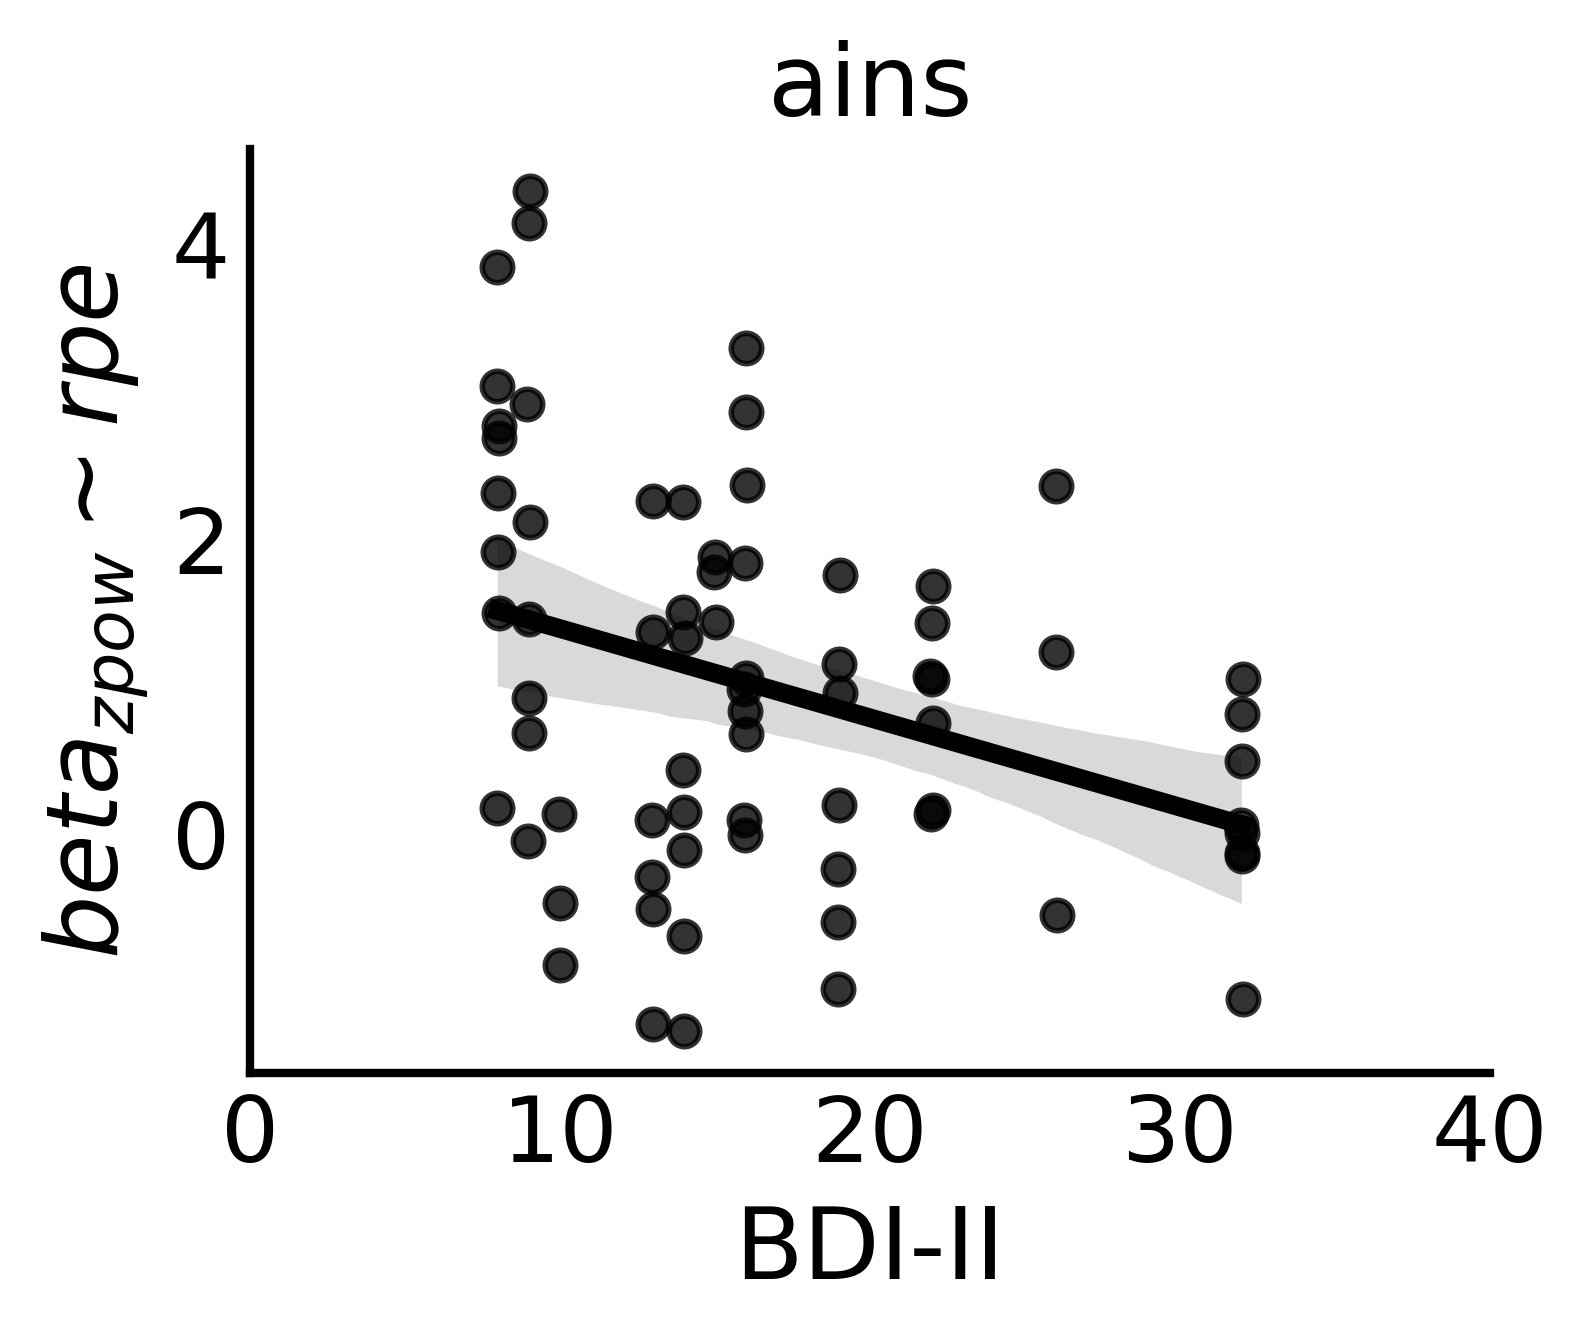

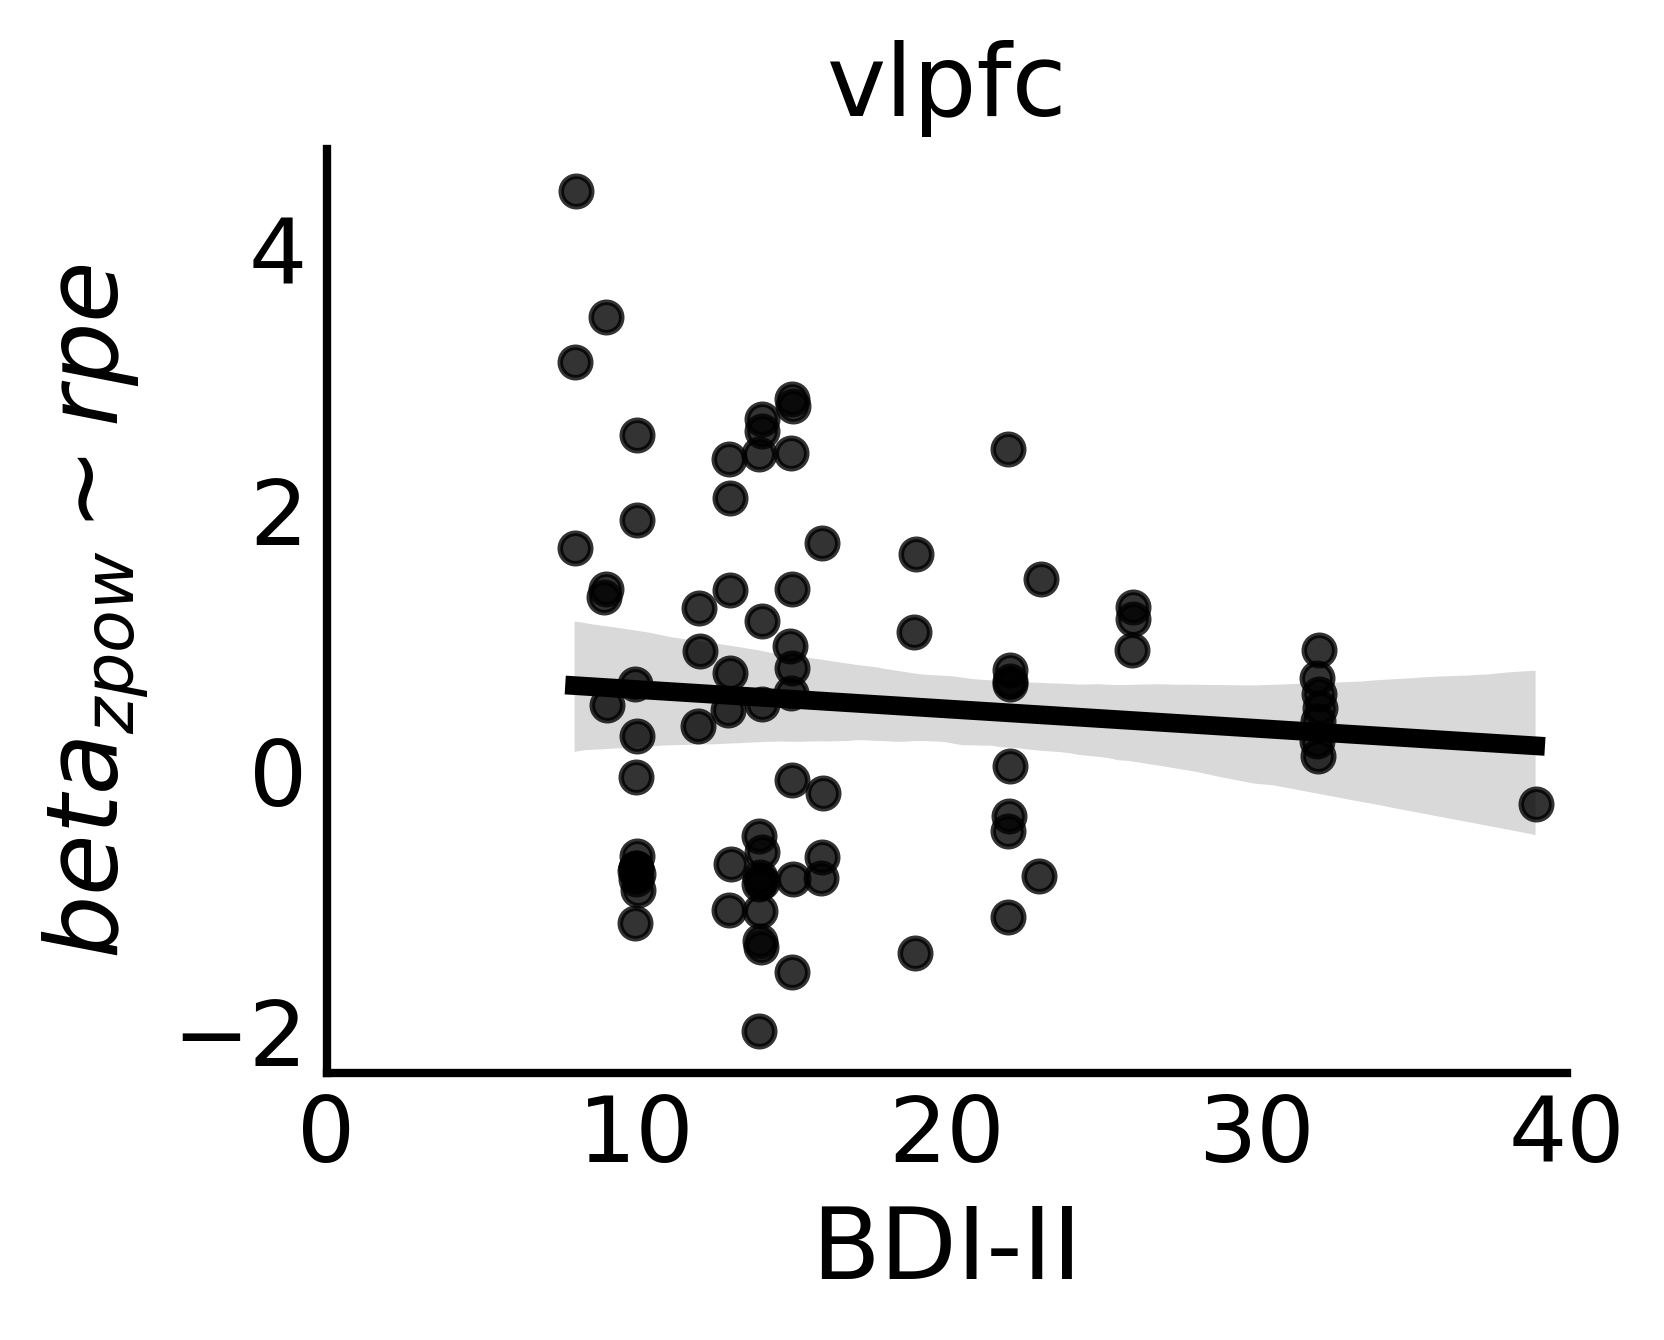

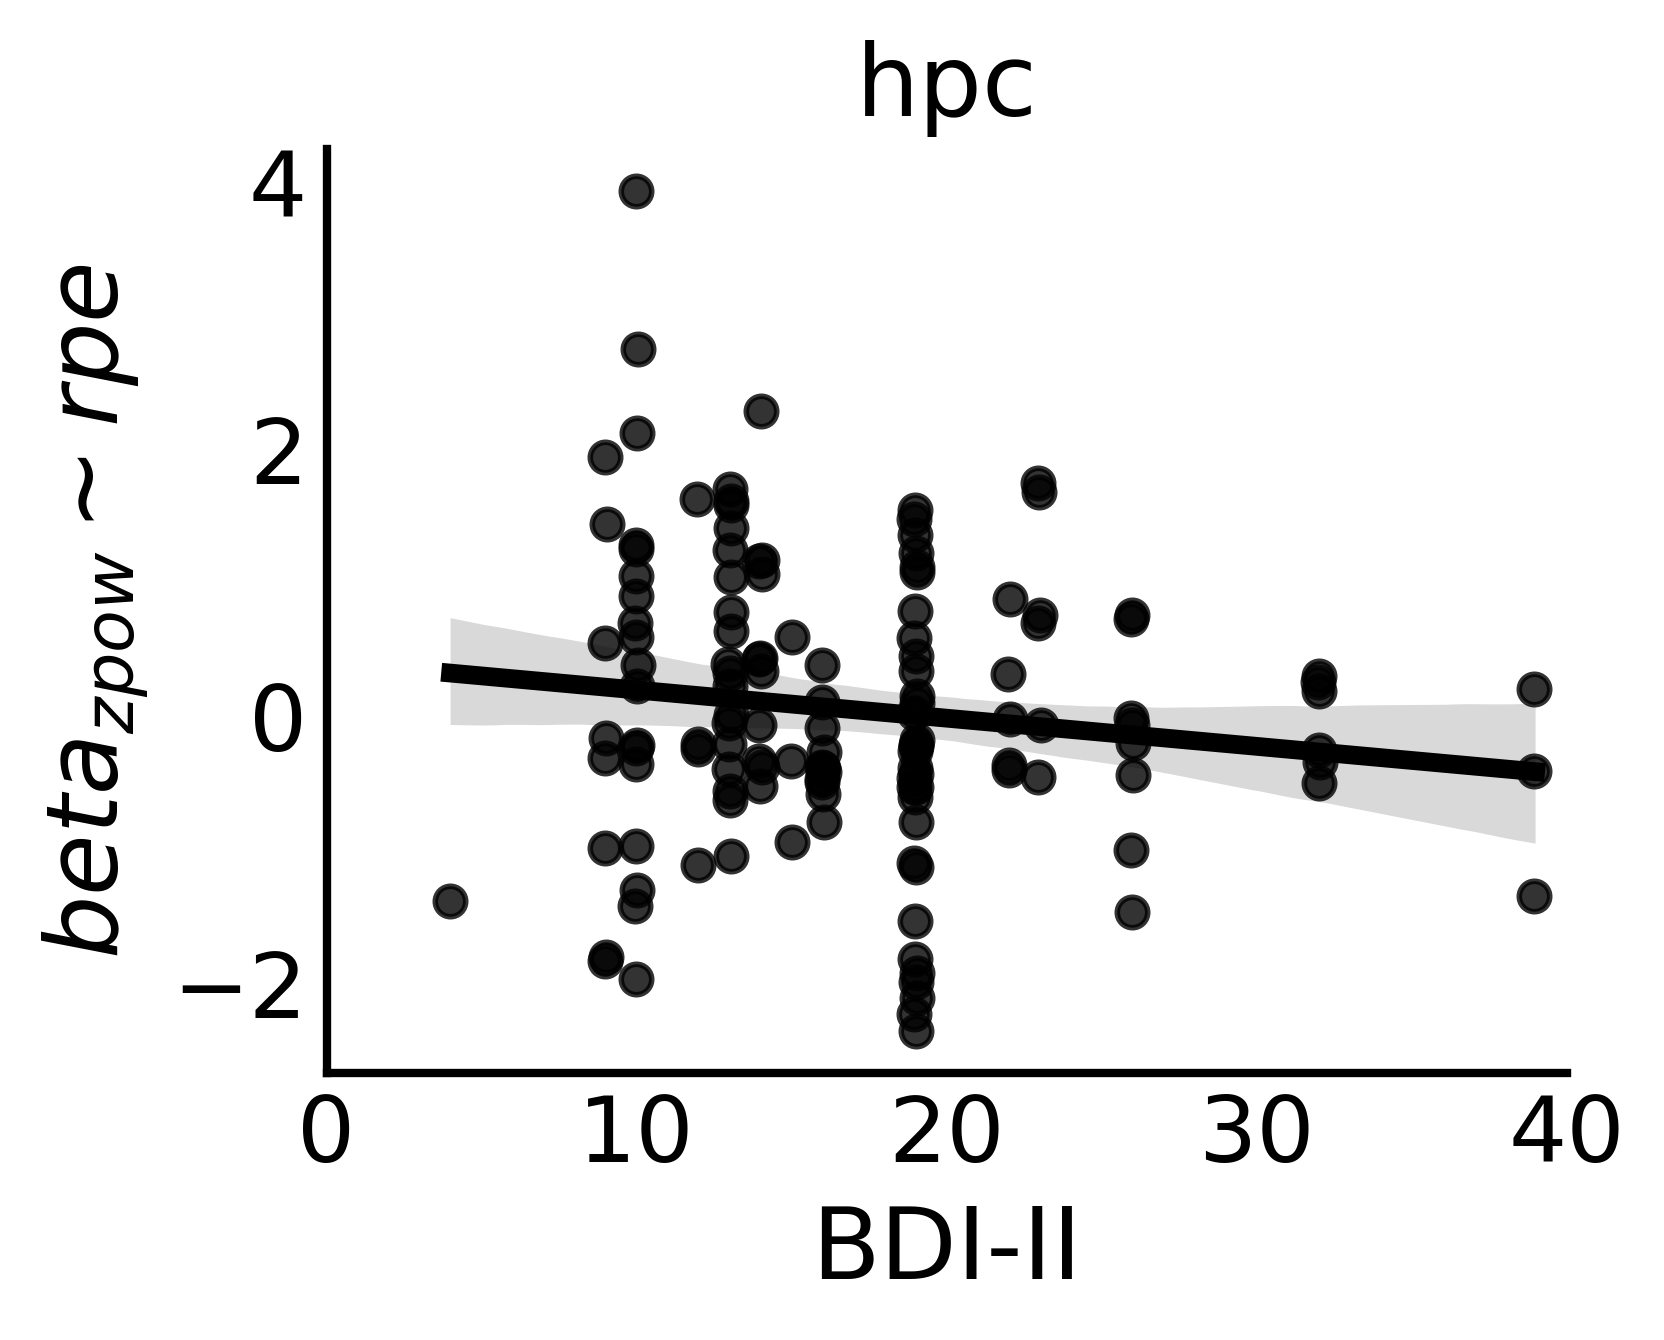

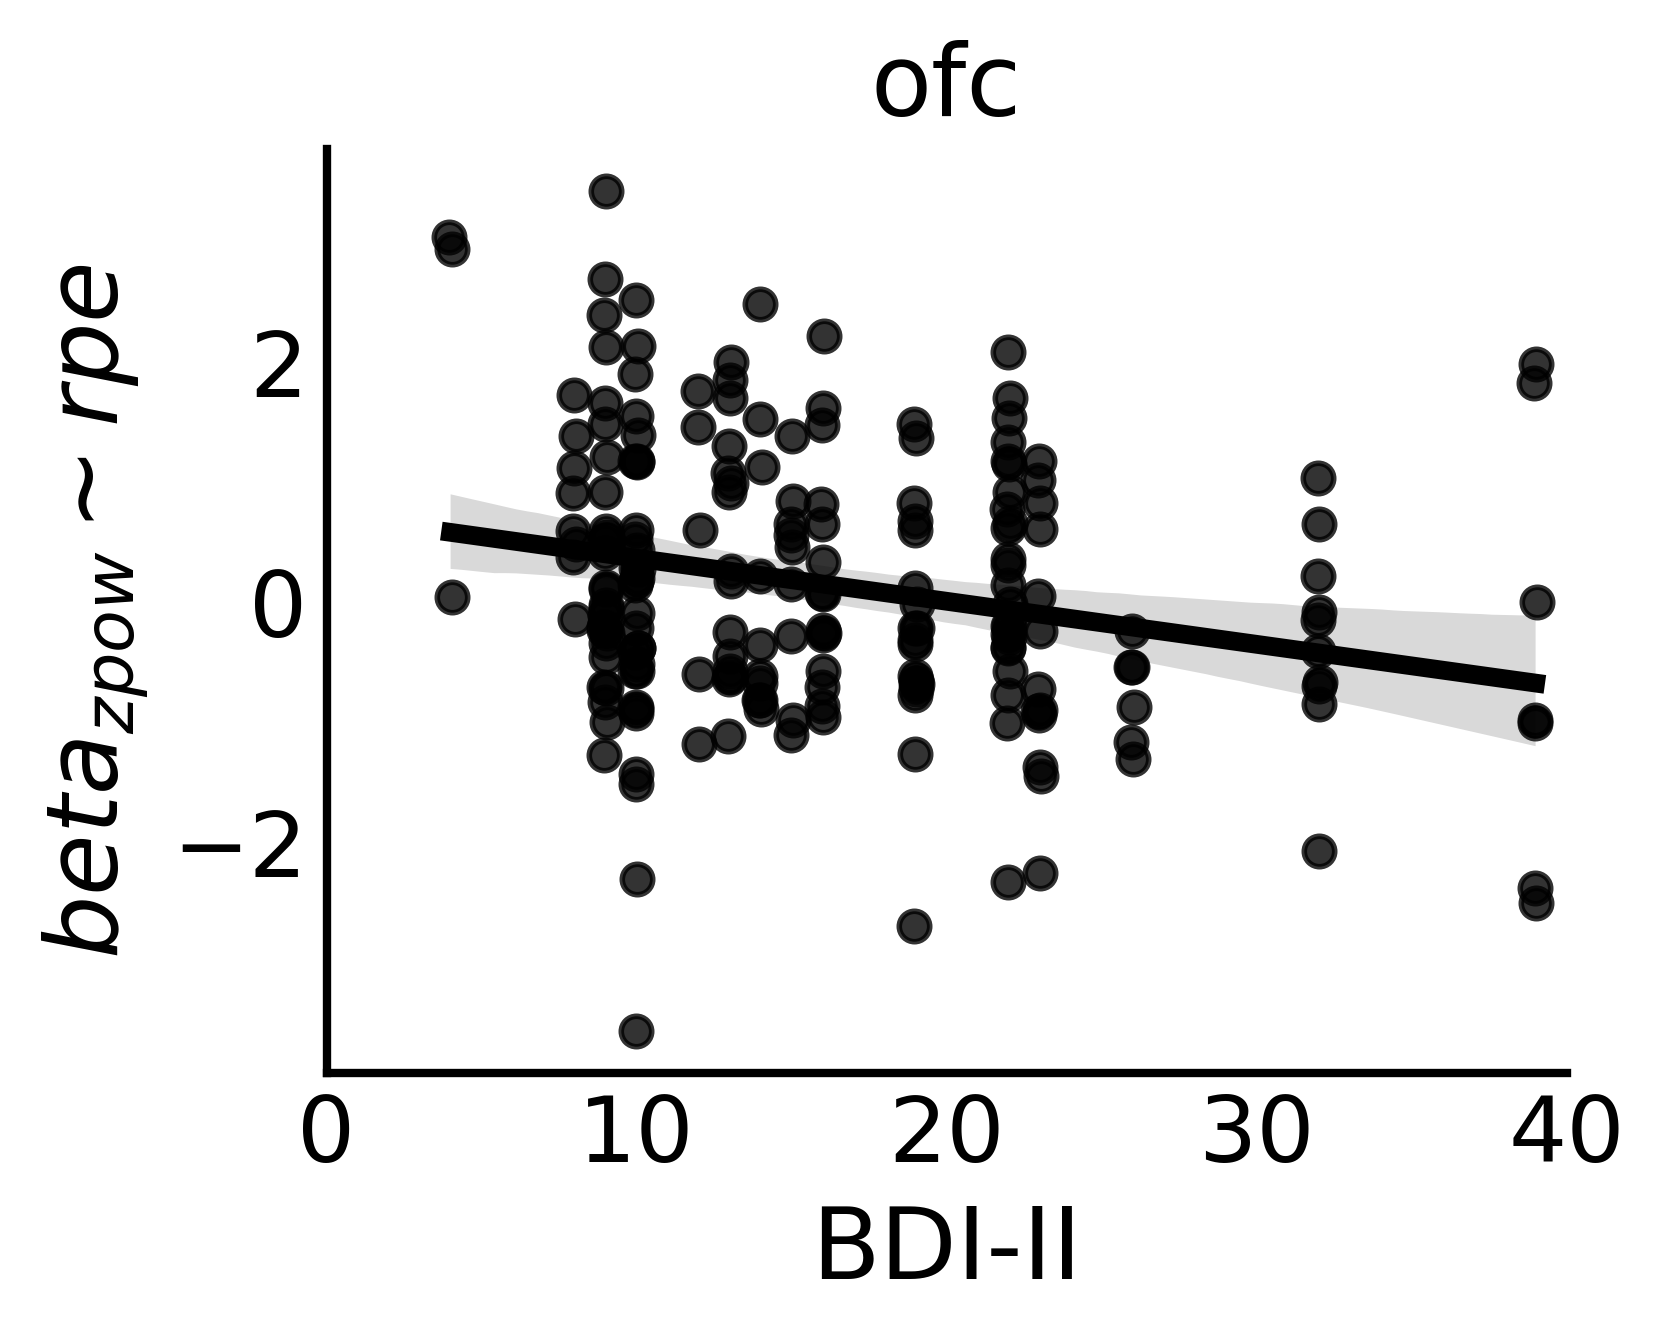

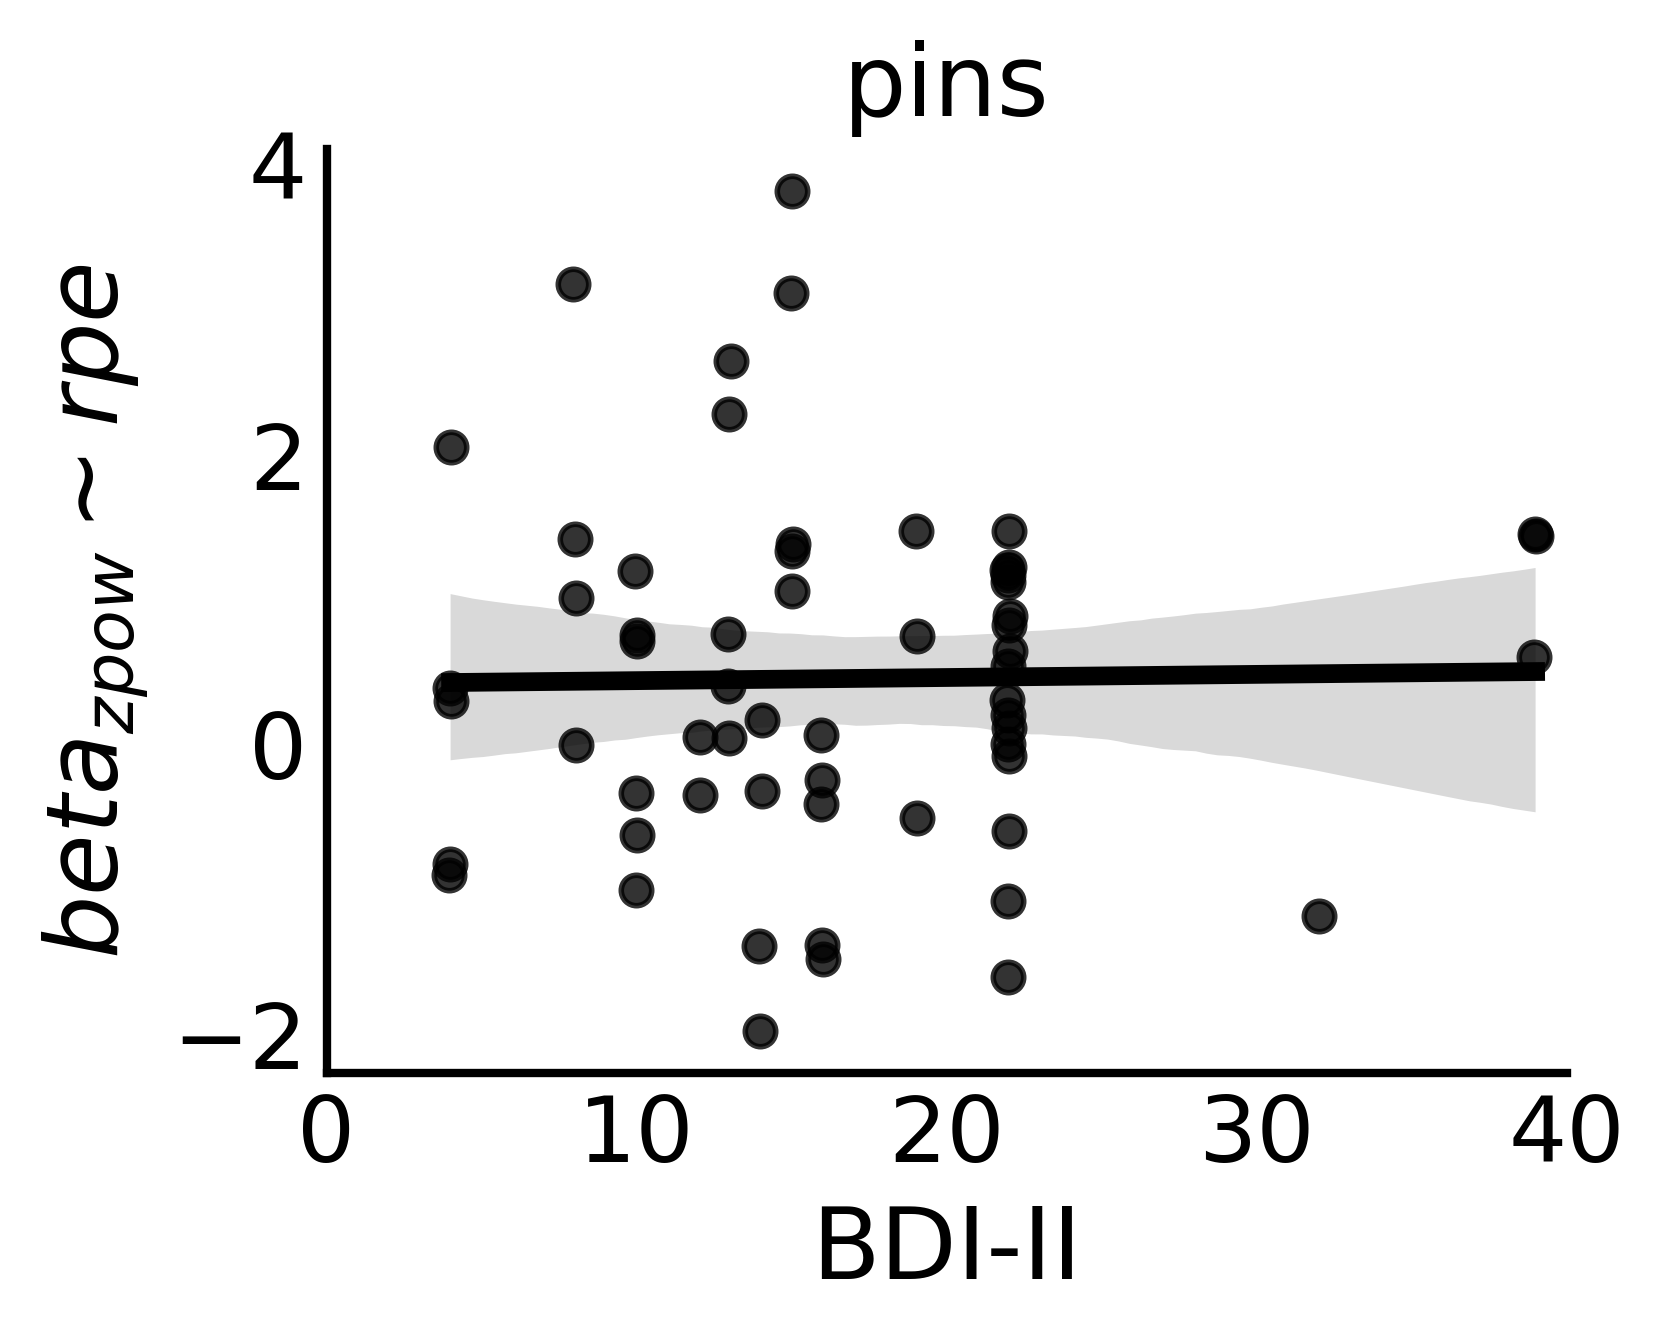

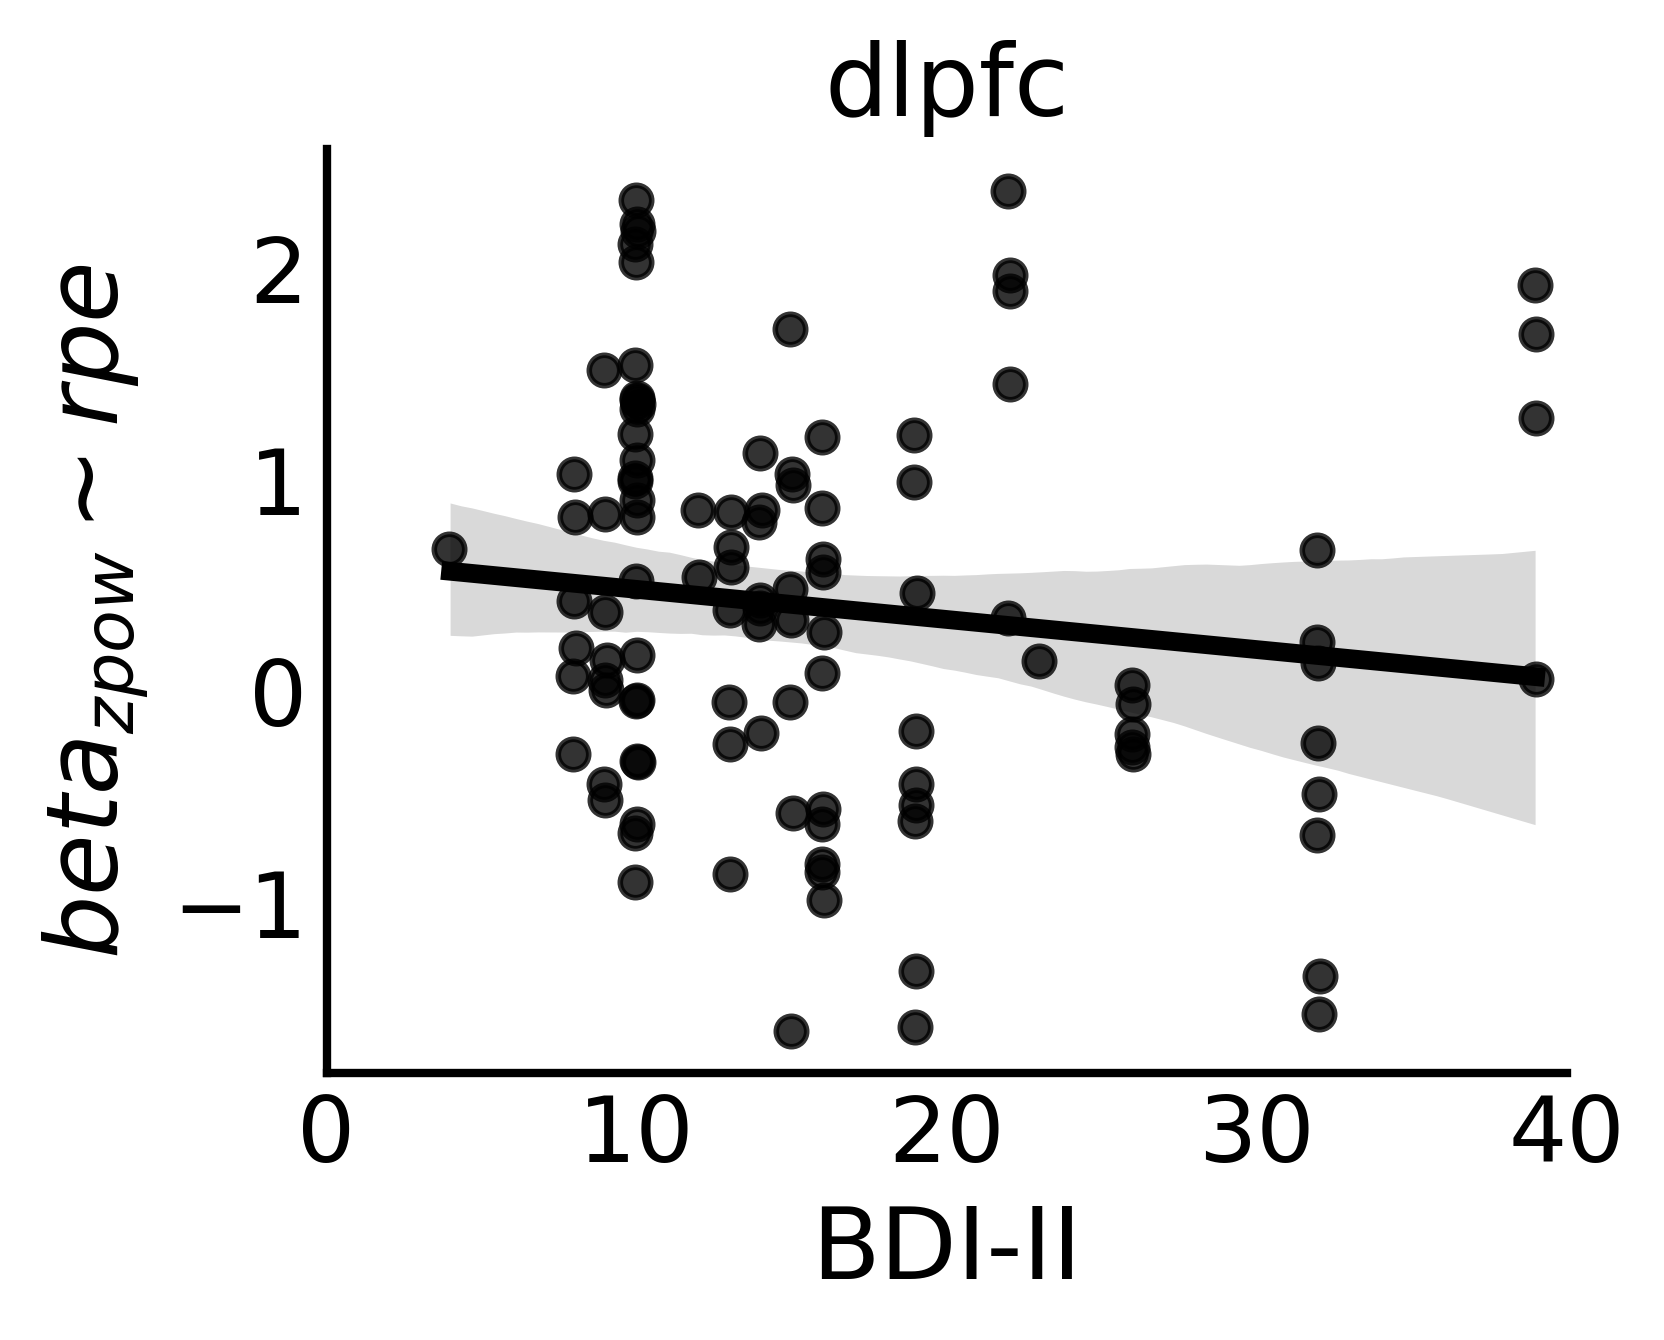

In [37]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_{main_var}_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [38]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        19:48:57                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1957      0.437     37.047     

# PROFIT!! Electrode-wise Regressions + Permutations

In [39]:
elec_col    = 'unique_reref_ch'
main_var    = 'Profit'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit'
n_permutations = 1000


In [40]:
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3698.40it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3717.73it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3808.39it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3696.86it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3675.62it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3670.23it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3656.12it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3667.10it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3645.27it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3683.68it/s]


In [41]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit']

In [42]:
results = single_elec_permutation_results(results_dict,beta_reg_df,save_vars)
results



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.062710   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.059272   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.045826   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.007789   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.040332   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.030969   
1184  DA039_rpins2-rpins3   DA039   pins   22                     0.062285   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.006558   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                     0.017363   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.108508   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.124002                  -0.038647   
1                                  -0.081039                  -0.043444   
2                                  -0.079749                  -0.057263   
3                                  -0.021639                   0.095624   
4                                  -0.044191                  -0.010985   
...                                      ...                        ...   
1183                               -0.005916                  -0.028661   
1184                               -0.000371                  -0.048807   
1185                               -0.127986                  -0.070706   
1186                               -0.052386                   0.002333   
1187                               -0.158913                  -0.126979   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                     0.106999                -0.021843   
1                     0.083709                 0.001711   
2                     0.112518                -0.007812   
3                    -0.049059                -0.006622   
4                    -0.000057                 0.009935   
...                        ...                      ...   
1183                  0.068785                 0.028709   
1184                  0.078870                 0.060419   
1185                  0.064958                -0.059504   
1186                  0.048323                -0.002500   
1187                  0.160894                 0.041856   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                              -0.001985  ...              0.055412   
1                               0.001979  ...              0.049844   
2                              -0.002354  ...              0.049041   
3                              -0.000562  ...              0.047878   
4                              -0.000428  ...              0.053043   
...                                  ...  ...                   ...   
1183                           -0.000939  ...              0.051758   
1184                            0.001051  ...              0.063779   
1185                           -0.001660  ...              0.054885   
1186                           -0.000245  ...              0.050398   
1187                           -0.001849  ...              0.068643   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0                0.052924           2.758806                     -2.765871   
1                0.048433           1.948716                     -1.952886   
2                0.049079           1.894452                     -1.898510   
3                0.049744           0.521510                     -0.529853   
4                0.049397           1.005720                     -1.006120   
...                   ...                ...                           ...   
1183             0.045034           0.127989                     

In [43]:
results.columns



Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TrialEV', 'Original_Estimate_Profit',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TrialEV', 'Permuted_Mean_Profit',
       'Permuted_Std_Intercept', 'Permuted_Std_GambleChoice[T.safe]',
       'Permuted_Std_TrialEV', 'Permuted_Std_Profit', 'Z_Score_Intercept',
       'Z_Score_GambleChoice[T.safe]', 'Z_Score_TrialEV', 'Z_Score_Profit',
       'P_Value_Intercept', 'P_Value_GambleChoice[T.safe]', 'P_Value_TrialEV',
       'P_Value_Profit'],
      dtype='object')

### Save results as pickle file

In [44]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_{main_var}_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [45]:
# save_path = f'{save_dir}/{band}/'
# os.makedirs(save_path, exist_ok=True)

# fname = f'{save_path}{band}_perm_regression_results_{epoch_len}.pkl'
# pickle.dump(results, open(fname,"wb"))


In [46]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.062710   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.045826   
30    MS002_lloif7-lloif8   MS002  vlpfc   14                     0.172738   
33    MS002_lmoif8-lmoif9   MS002  vlpfc   14                     0.145871   
48    MS002_racas1-racas2   MS002    acc   14                    -0.015750   
...                   ...     ...    ...  ...                          ...   
1169      DA039_rfp4-rfp5   DA039    ofc   22                    -0.079764   
1179      DA039_rof8-rof9   DA039  dlpfc   22                     0.050133   
1181    DA039_rof10-rof11   DA039  dlpfc   22                     0.055158   
1182    DA039_rof11-rof12   DA039  dlpfc   22                    -0.008054   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                     0.108508   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.124002                  -0.038647   
2                                  -0.079749                  -0.057263   
30                                 -0.210590                  -0.188024   
33                                 -0.237840                  -0.158571   
48                                 -0.006291                  -0.101122   
...                                      ...                        ...   
1169                                0.005633                  -0.002355   
1179                               -0.101338                  -0.063917   
1181                               -0.107815                  -0.055385   
1182                               -0.058411                  -0.001971   
1187                               -0.158913                  -0.126979   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                     0.106999                -0.021843   
2                     0.112518                -0.007812   
30                    0.165562                 0.027044   
33                    0.146864                -0.019447   
48                    0.129413                -0.019831   
...                        ...                      ...   
1169                  0.013520                -0.077453   
1179                  0.123880                 0.008826   
1181                  0.127345                 0.010274   
1182                  0.061803                -0.030431   
1187                  0.160894                 0.041856   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                              -0.001985  ...              0.055412   
2                              -0.002354  ...              0.049041   
30                             -0.001000  ...              0.062287   
33                              0.000125  ...              0.065691   
48                             -0.000480  ...              0.044501   
...                                  ...  ...                   ...   
1169                            0.000094  ...              0.007578   
1179                           -0.000809  ...              0.056300   
1181                            0.002755  ...              0.050508   
1182                            0.000004  ...              0.030640   
1187                           -0.001849  ...              0.068643   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0                0.052924           2.758806                     -2.765871   
2                0.049079           1.894452                     -1.898510   
30               0.061040           3.957499                     -3.954624   
33               0.064689           4.293819                     -4.294319   
48               0.044218           0.161320                     -0.159566   
...                   ...                ...                           ...   
1169             0.006632          -0.894475                     

In [47]:
sig_data.roi.value_counts()



roi
acc      26
ofc      21
dmpfc    20
ains     14
vlpfc    13
hpc       8
amy       8
dlpfc     8
pins      6
Name: count, dtype: int64

In [48]:
sig_data.roi.unique()



array(['acc', 'vlpfc', 'dmpfc', 'hpc', 'ofc', 'amy', 'ains', 'pins',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [49]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.062710   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.059272   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.045826   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.007789   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.040332   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.124002                  -0.038647   
1                               -0.081039                  -0.043444   
2                               -0.079749                  -0.057263   
3                               -0.021639                   0.095624   
4                               -0.044191                  -0.010985   

   Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                  0.106999                -0.021843   
1                  0.083709                 0.001711   
2                  0.112518                -0.007812   
3                 -0.049059                -0.006622   
4                 -0.000057                 0.009935   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                           -0.001985  ...           2.758806   
1                            0.001979  ...           1.948716   
2                           -0.002354  ...           1.894452   
3                           -0.000562  ...           0.521510   
4                           -0.000428  ...           1.005720   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
0                     -2.765871        -0.680549        1.983966   
1                     -1.952886        -0.847513        1.690606   
2                     -1.898510        -1.177435        2.327277   
3                     -0.529853         1.966978       -0.928849   
4                     -1.006120        -0.163157       -0.016781   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.005801                      0.005677         0.496157   
1           0.051329                      0.050833         0.396709   
2           0.058165                      0.057629         0.239022   
3           0.602012                      0.596214         0.049186   
4           0.314550                      0.314358         0.870395   

   P_Value_Profit  Profit_sig  bdi_split  
0        0.047260           1          0  
1        0.090912           0          0  
2        0.019951           1          0  
3        0.352967           0          0  
4        0.986611           0          0  

[5 rows x 26 columns]

In [50]:
Profit_var = 'Z_Score_Profit'

In [51]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [52]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc    0.421640
vlpfc    0.551909
dmpfc    0.098615
ofc      0.106219
ains     0.993905
pins     0.521631
acc      0.387826
amy      0.109517
hpc      0.083846
Name: Z_Score_Profit, dtype: float64

In [53]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [54]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     26  0.134715              4    4.259147  3.210309e-05   
1  dmpfc      225     20  0.088889              6    1.407000  1.608133e-01   
2    amy      113      8  0.070796              1    0.996614  3.211003e-01   
3   ains       71     14  0.197183              1    6.116111  4.881427e-08   
4  vlpfc       82     13  0.158537              1    3.703408  3.870842e-04   
5    hpc      135      8  0.059259              0    0.924799  3.567329e-01   
6    ofc      202     21  0.103960              6    1.316892  1.893741e-01   
7   pins       60      6  0.100000              0    3.221096  2.079288e-03   
8  dlpfc      107      8  0.074766              3    4.397514  2.612726e-05   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.096139            1.0    0.134715      0.0000  
1      0.059687            1.0    0.088889      0.0097  
2      0.035713            1.0    0.070796      0.2049  
3      0.123332            1.0    0.197183      0.0000  
4      0.096401            1.0    0.158537      0.0002  
5      0.029825            1.0    0.059259      0.3631  
6      0.070726            1.0    0.103960      0.0013  
7      0.044453            1.0    0.100000      0.0787  
8      0.037745            1.0    0.074766      0.1673

In [55]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     26  0.134715              4    4.259147  3.210309e-05   
1  dmpfc      225     20  0.088889              6    1.407000  1.608133e-01   
3   ains       71     14  0.197183              1    6.116111  4.881427e-08   
4  vlpfc       82     13  0.158537              1    3.703408  3.870842e-04   
6    ofc      202     21  0.103960              6    1.316892  1.893741e-01   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.096139            1.0    0.134715      0.0000  
1      0.059687            1.0    0.088889      0.0097  
3      0.123332            1.0    0.197183      0.0000  
4      0.096401            1.0    0.158537      0.0002  
6      0.070726            1.0    0.103960      0.0013

# Plot Results

In [56]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_{main_var}_coeff_barplot.pdf'
ylabel = fr'${band}_{{zpow}} \sim {main_var}$'


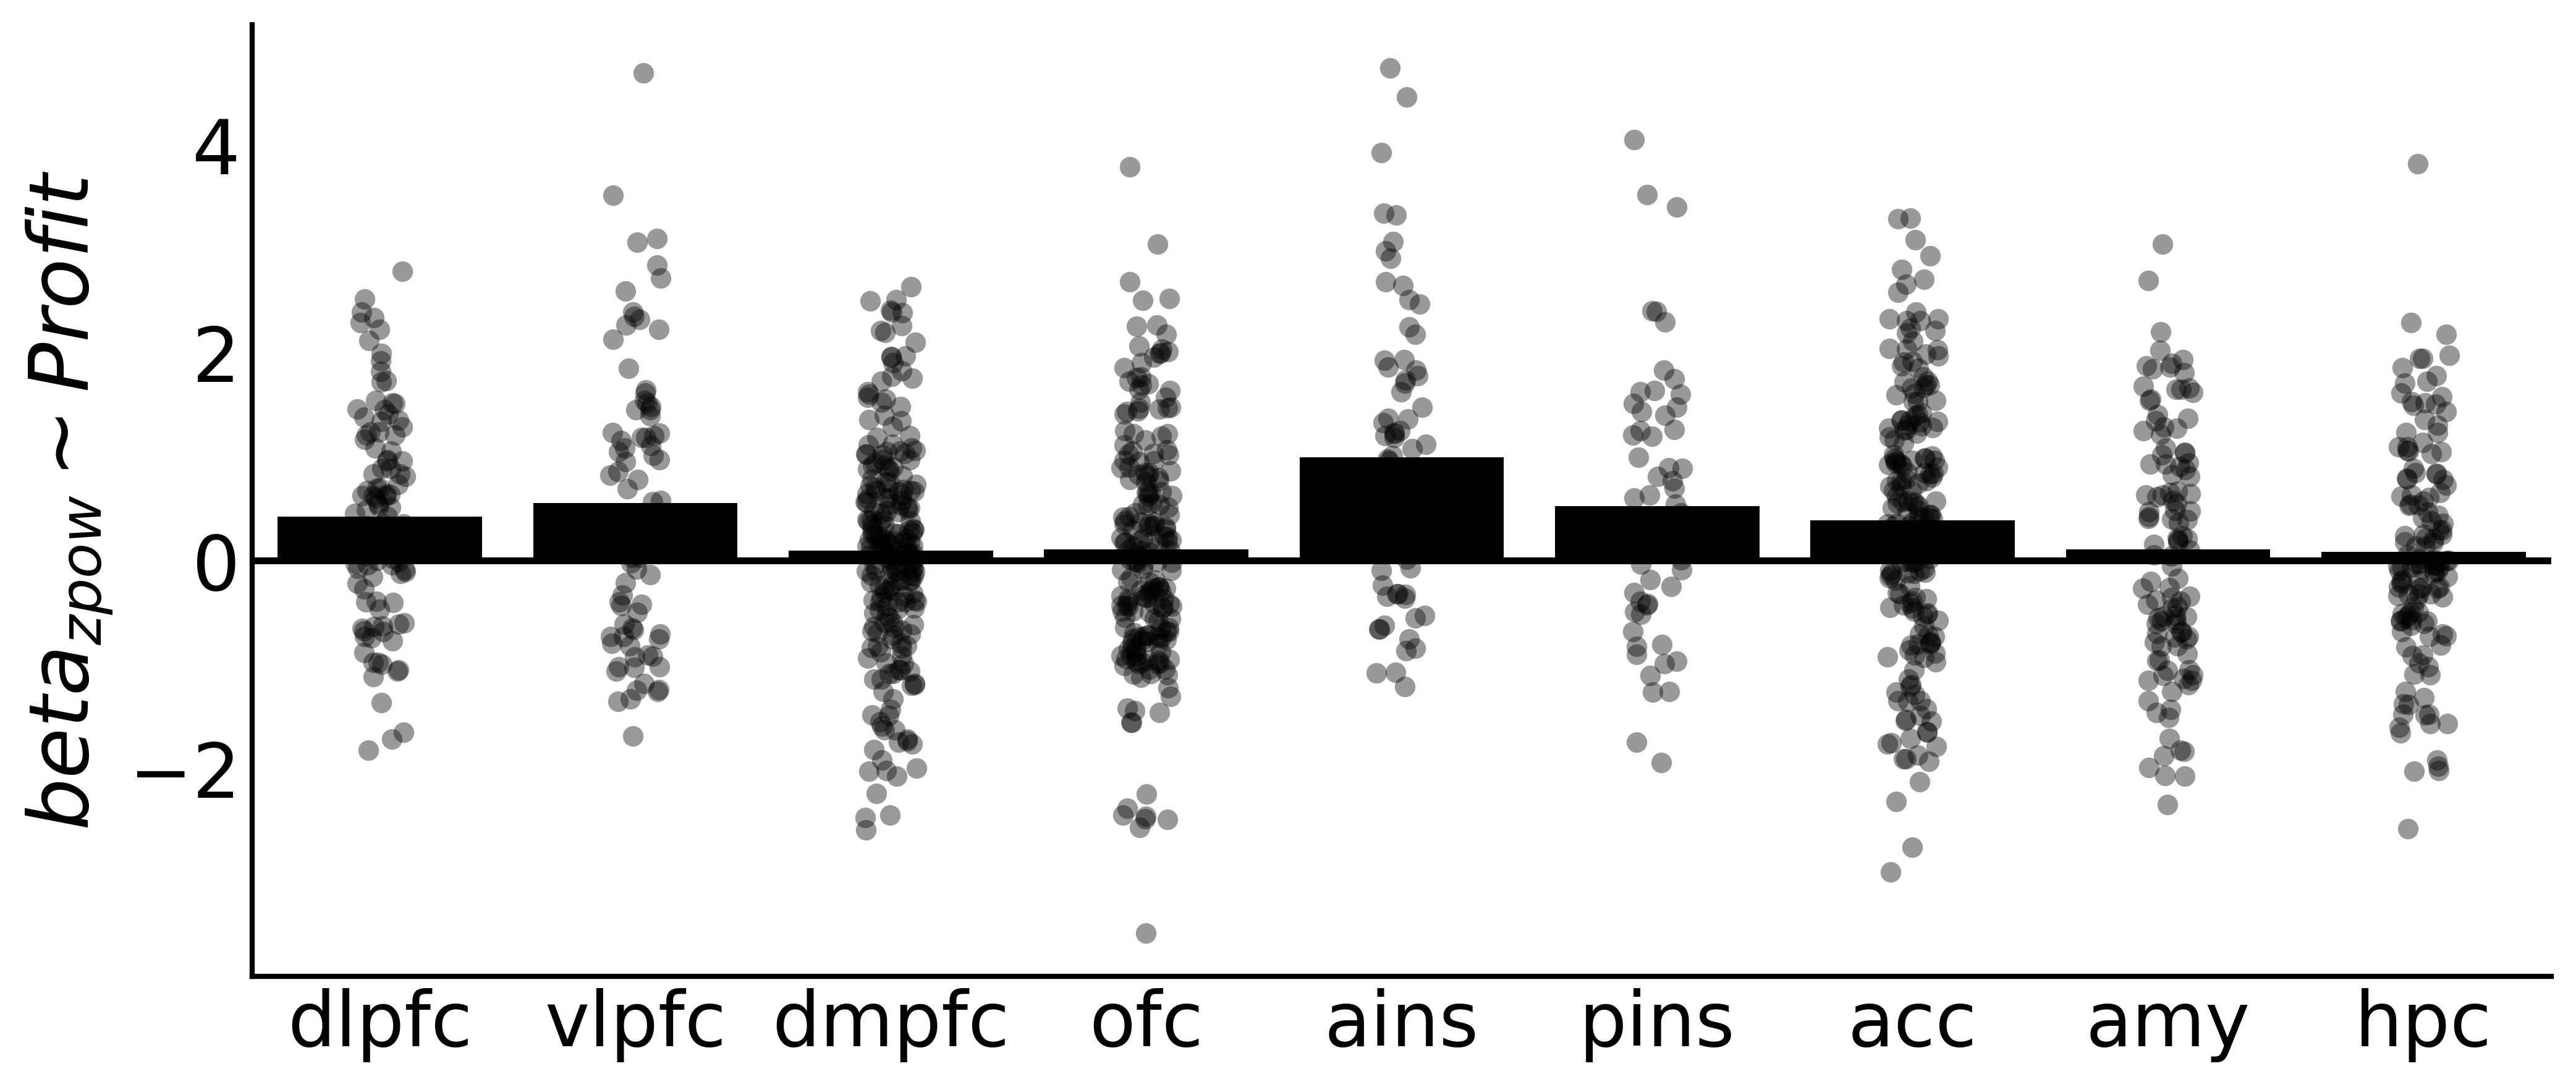

In [57]:
### WITHOUT RPE IN MODEL
plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

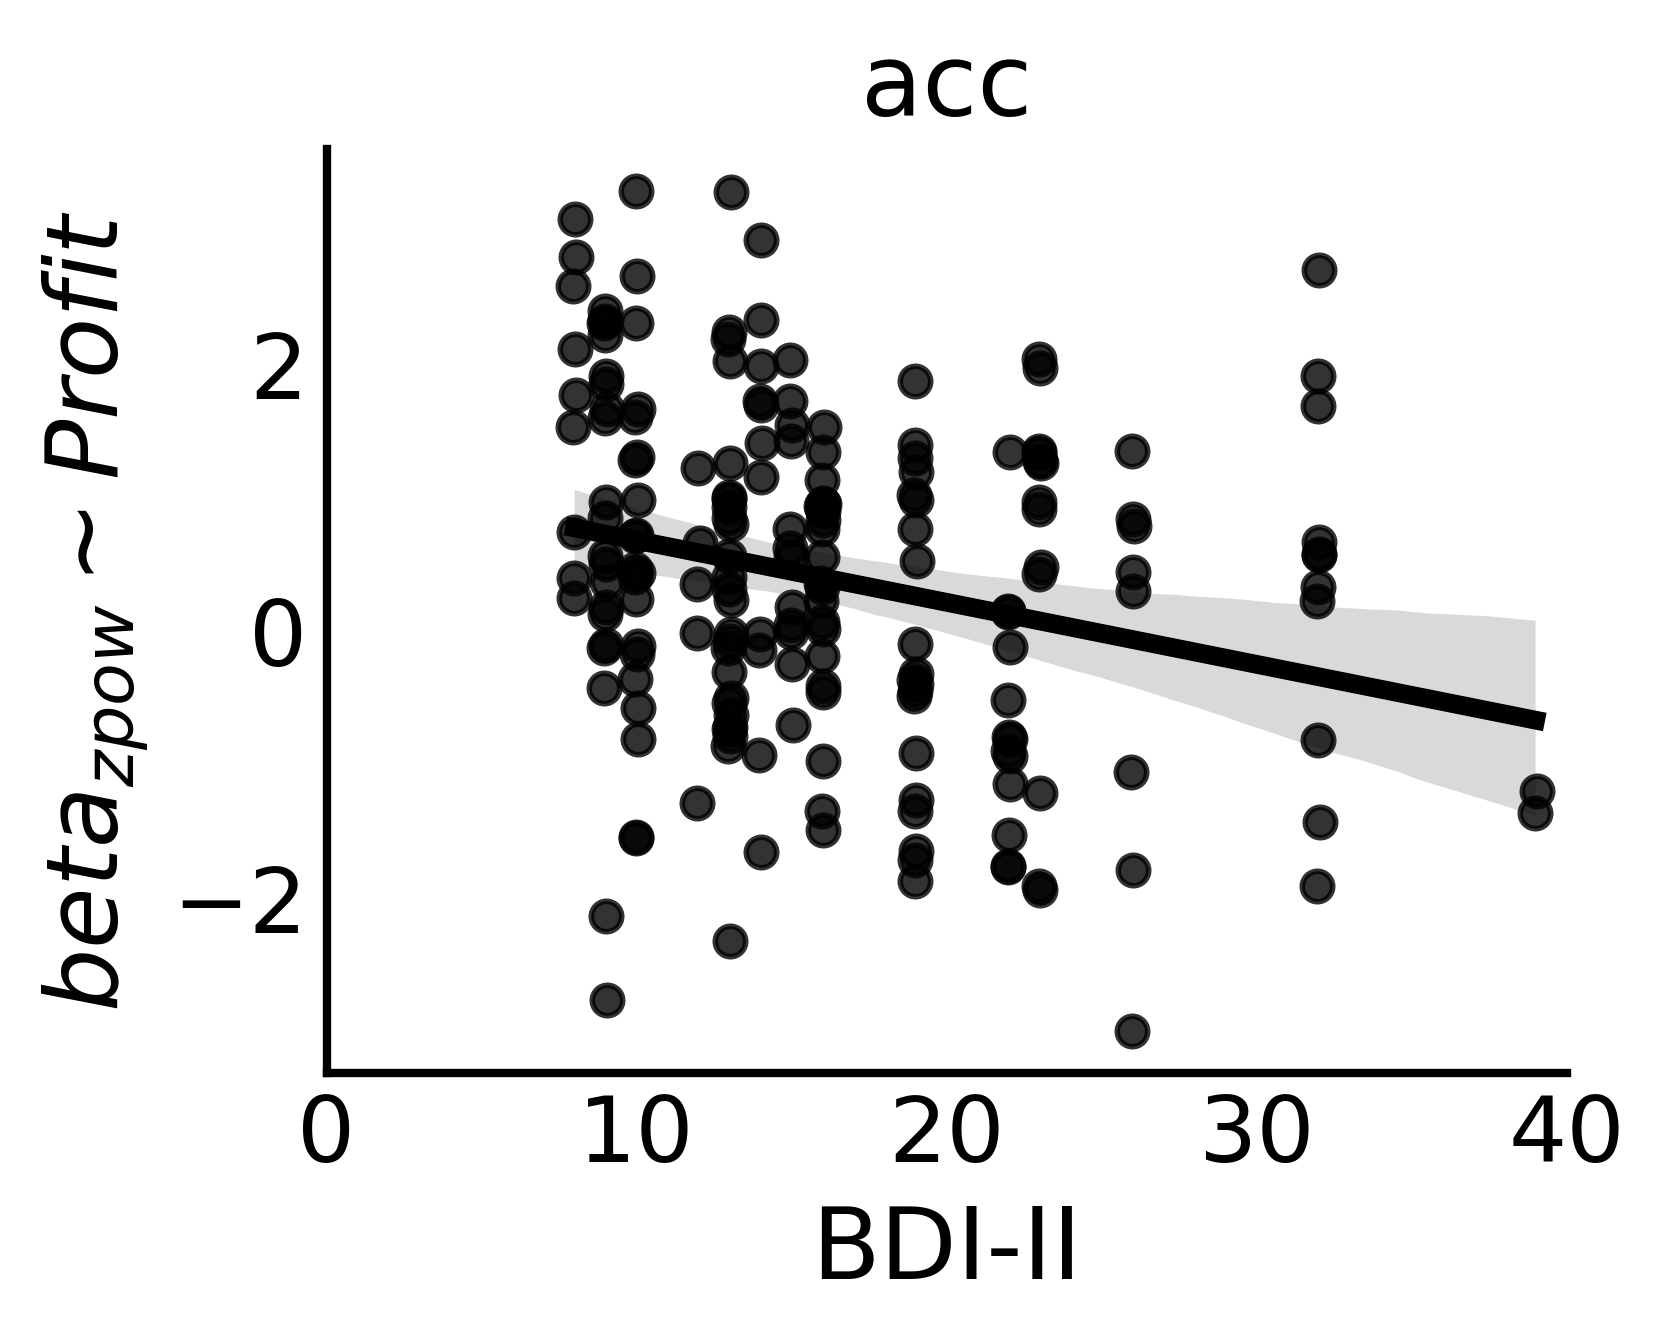

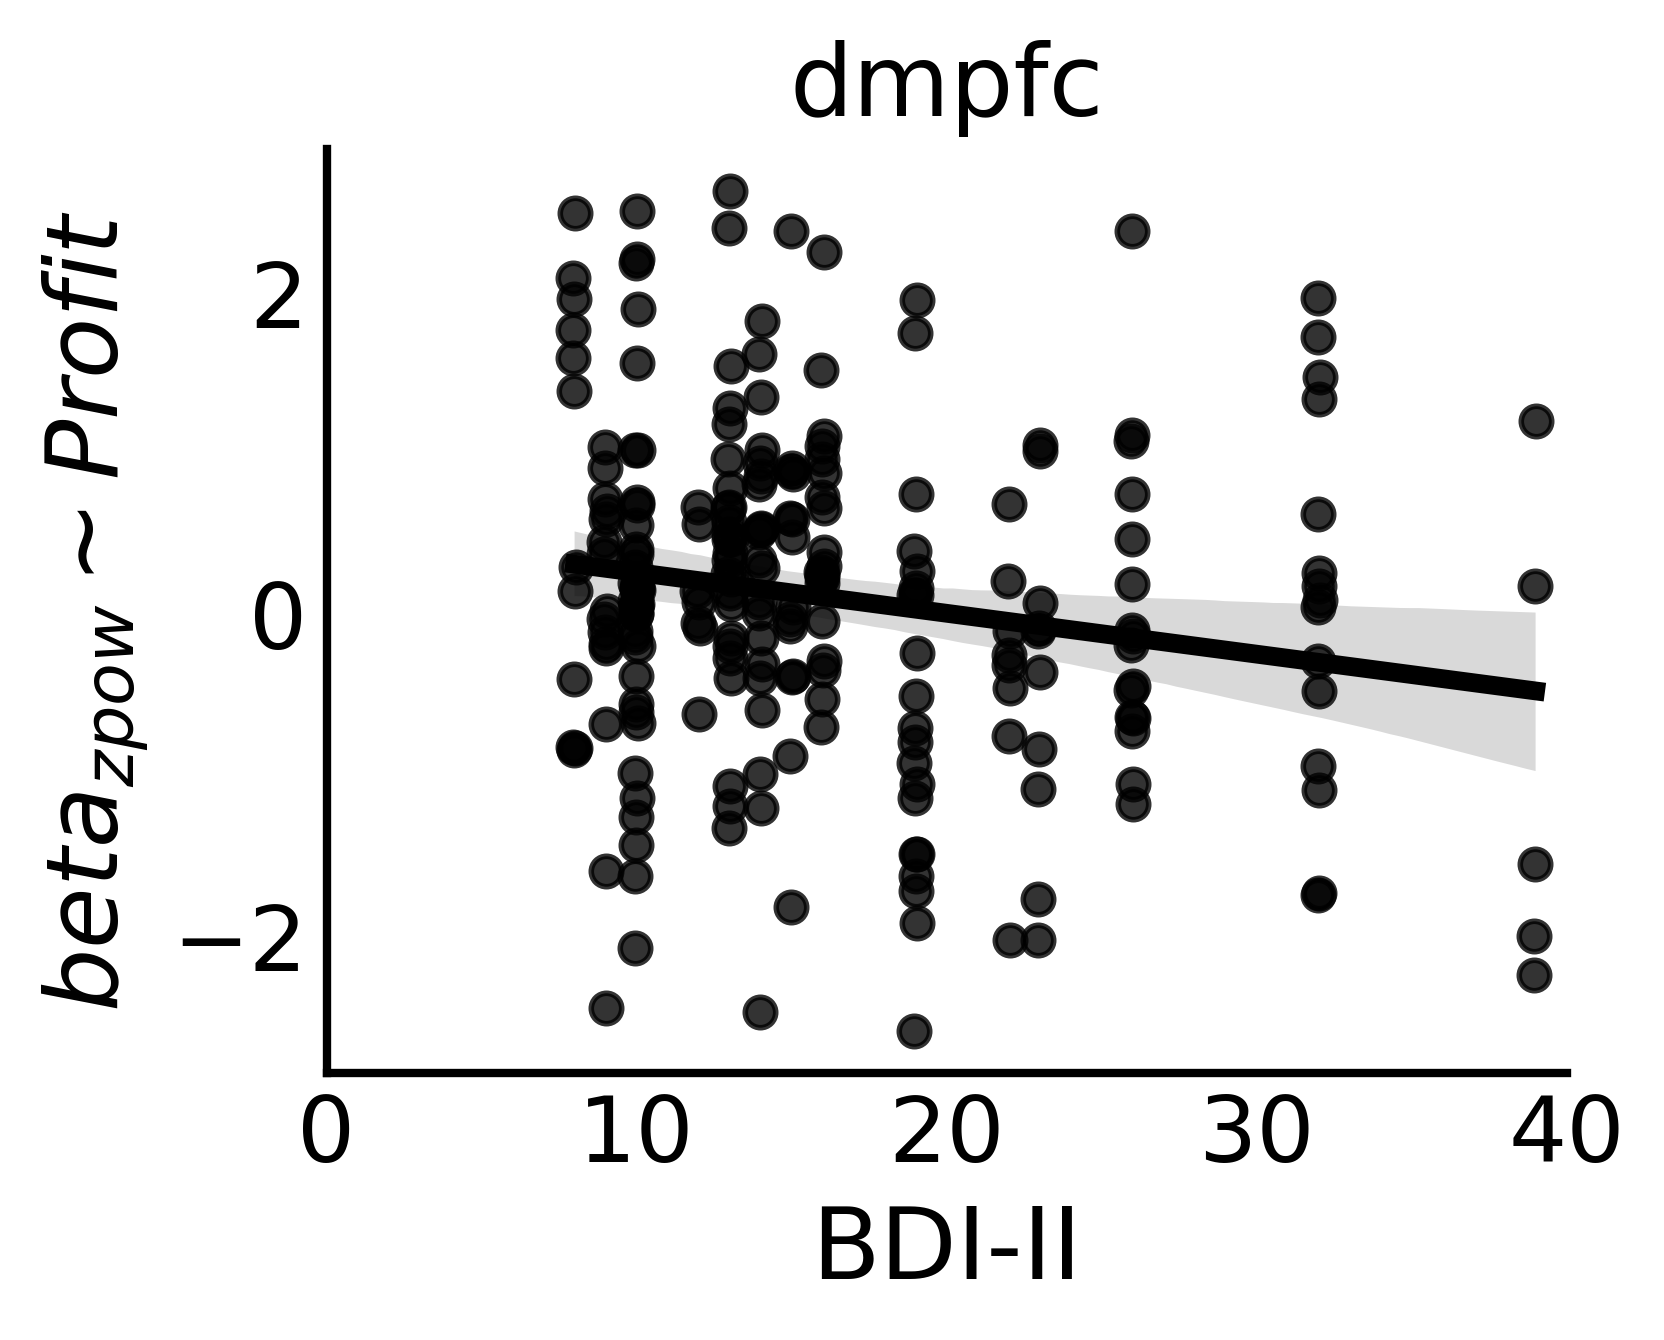

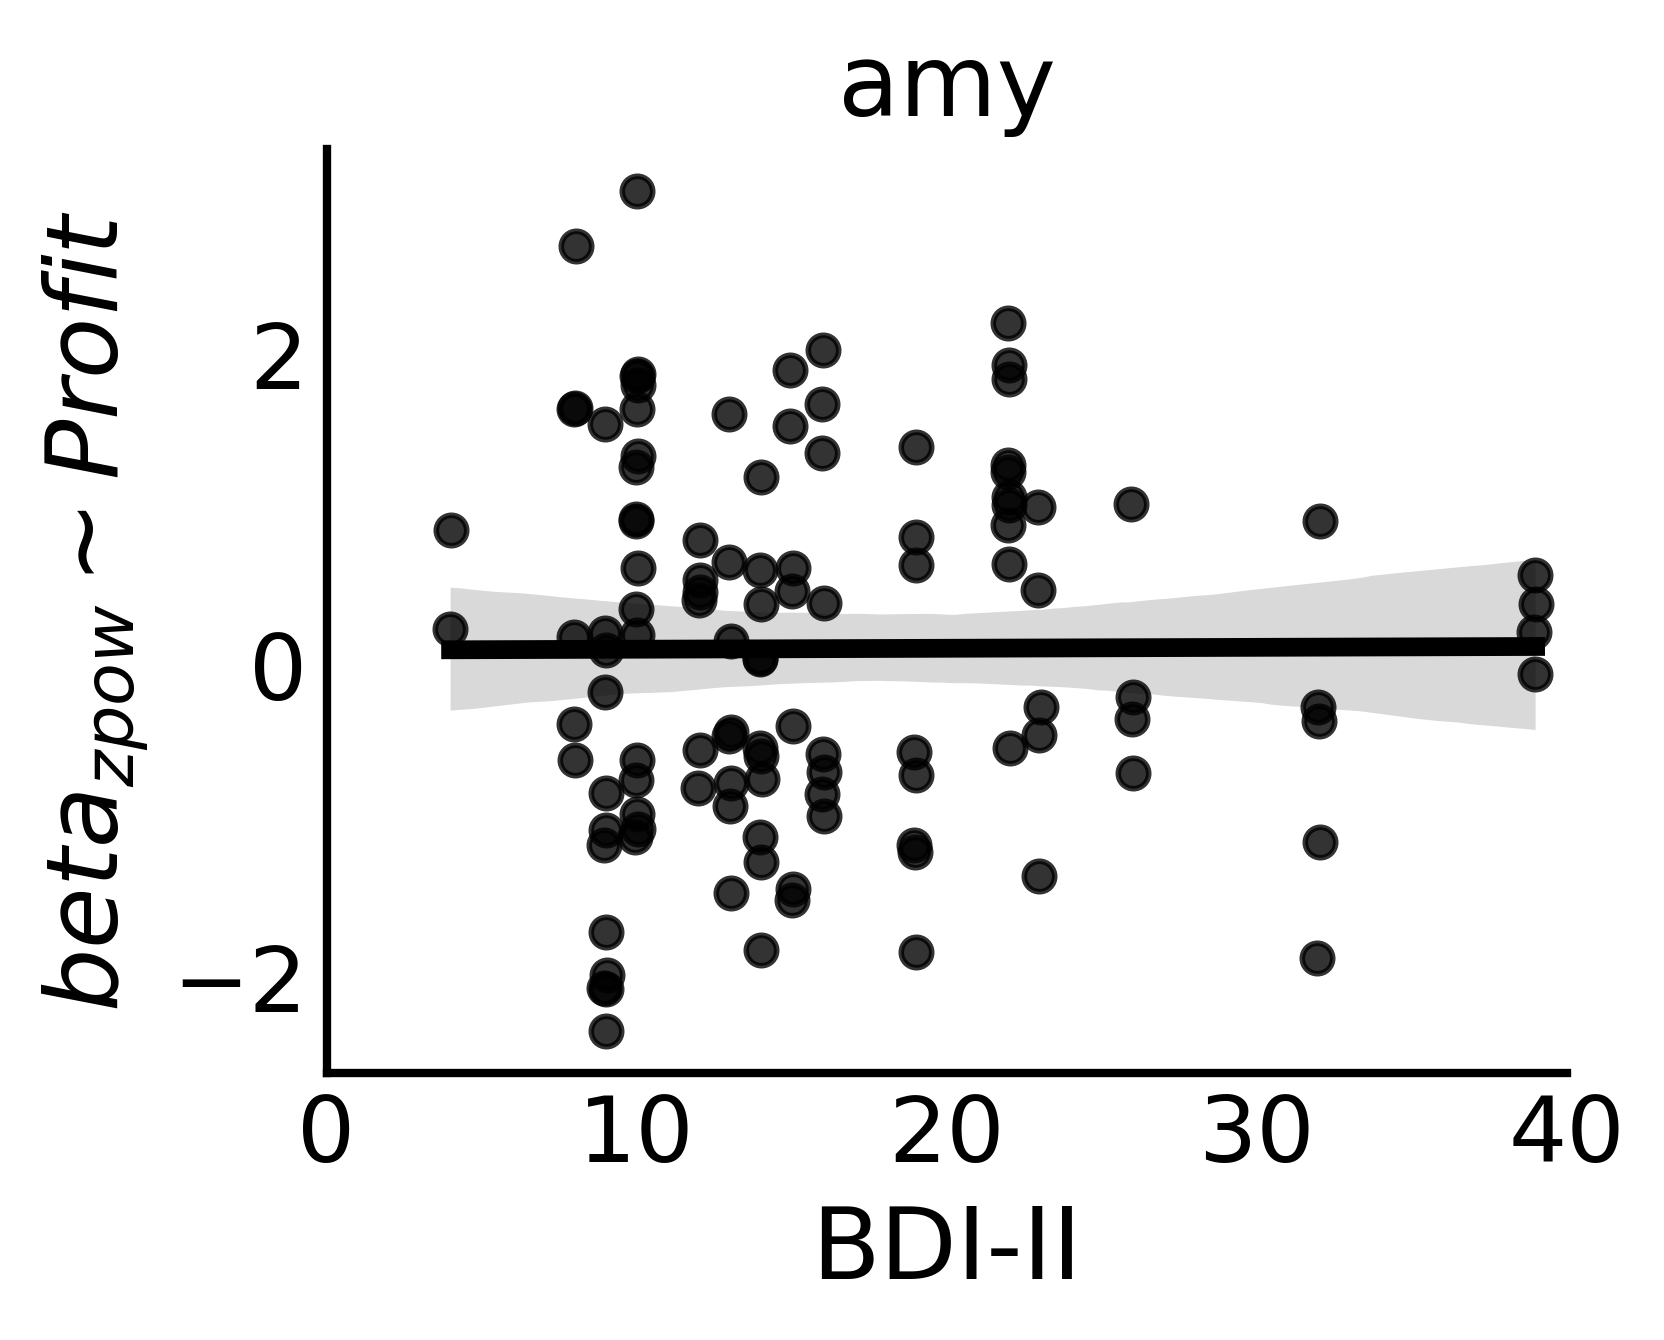

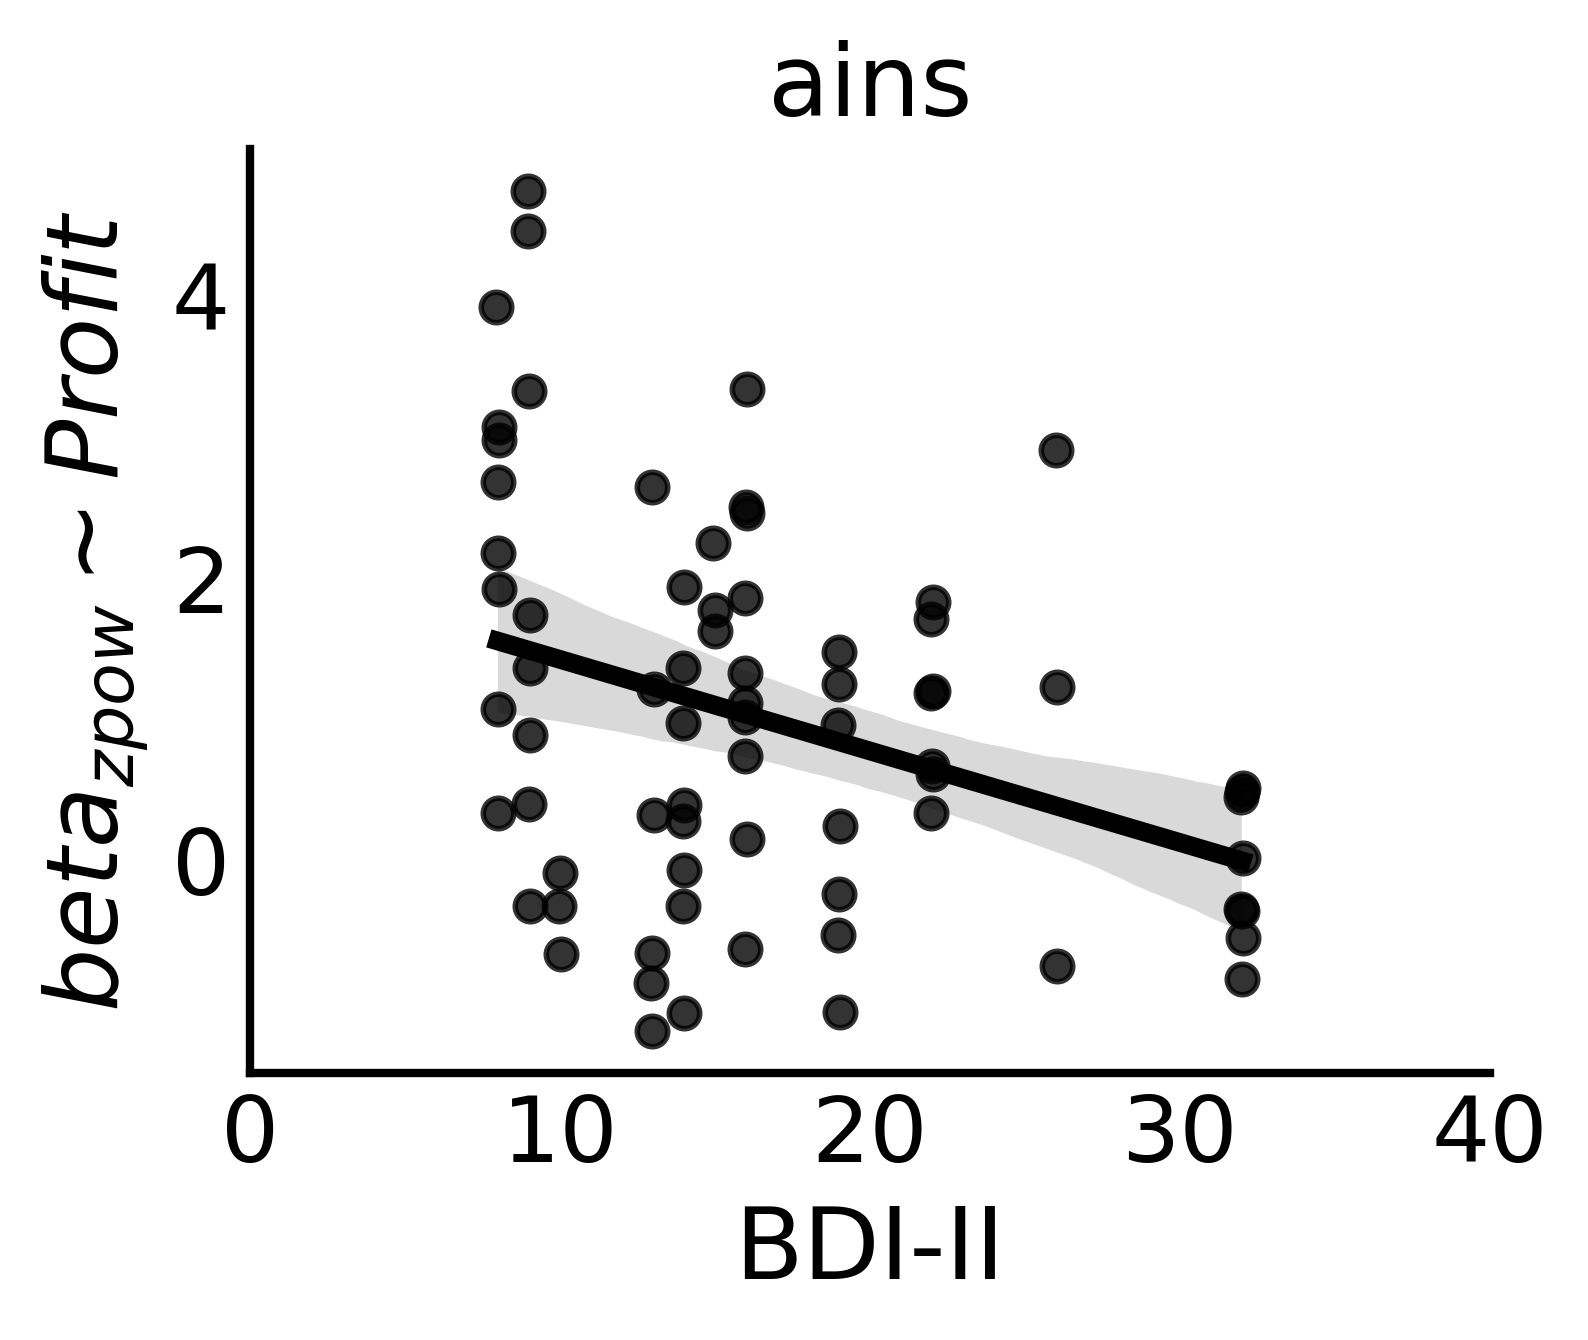

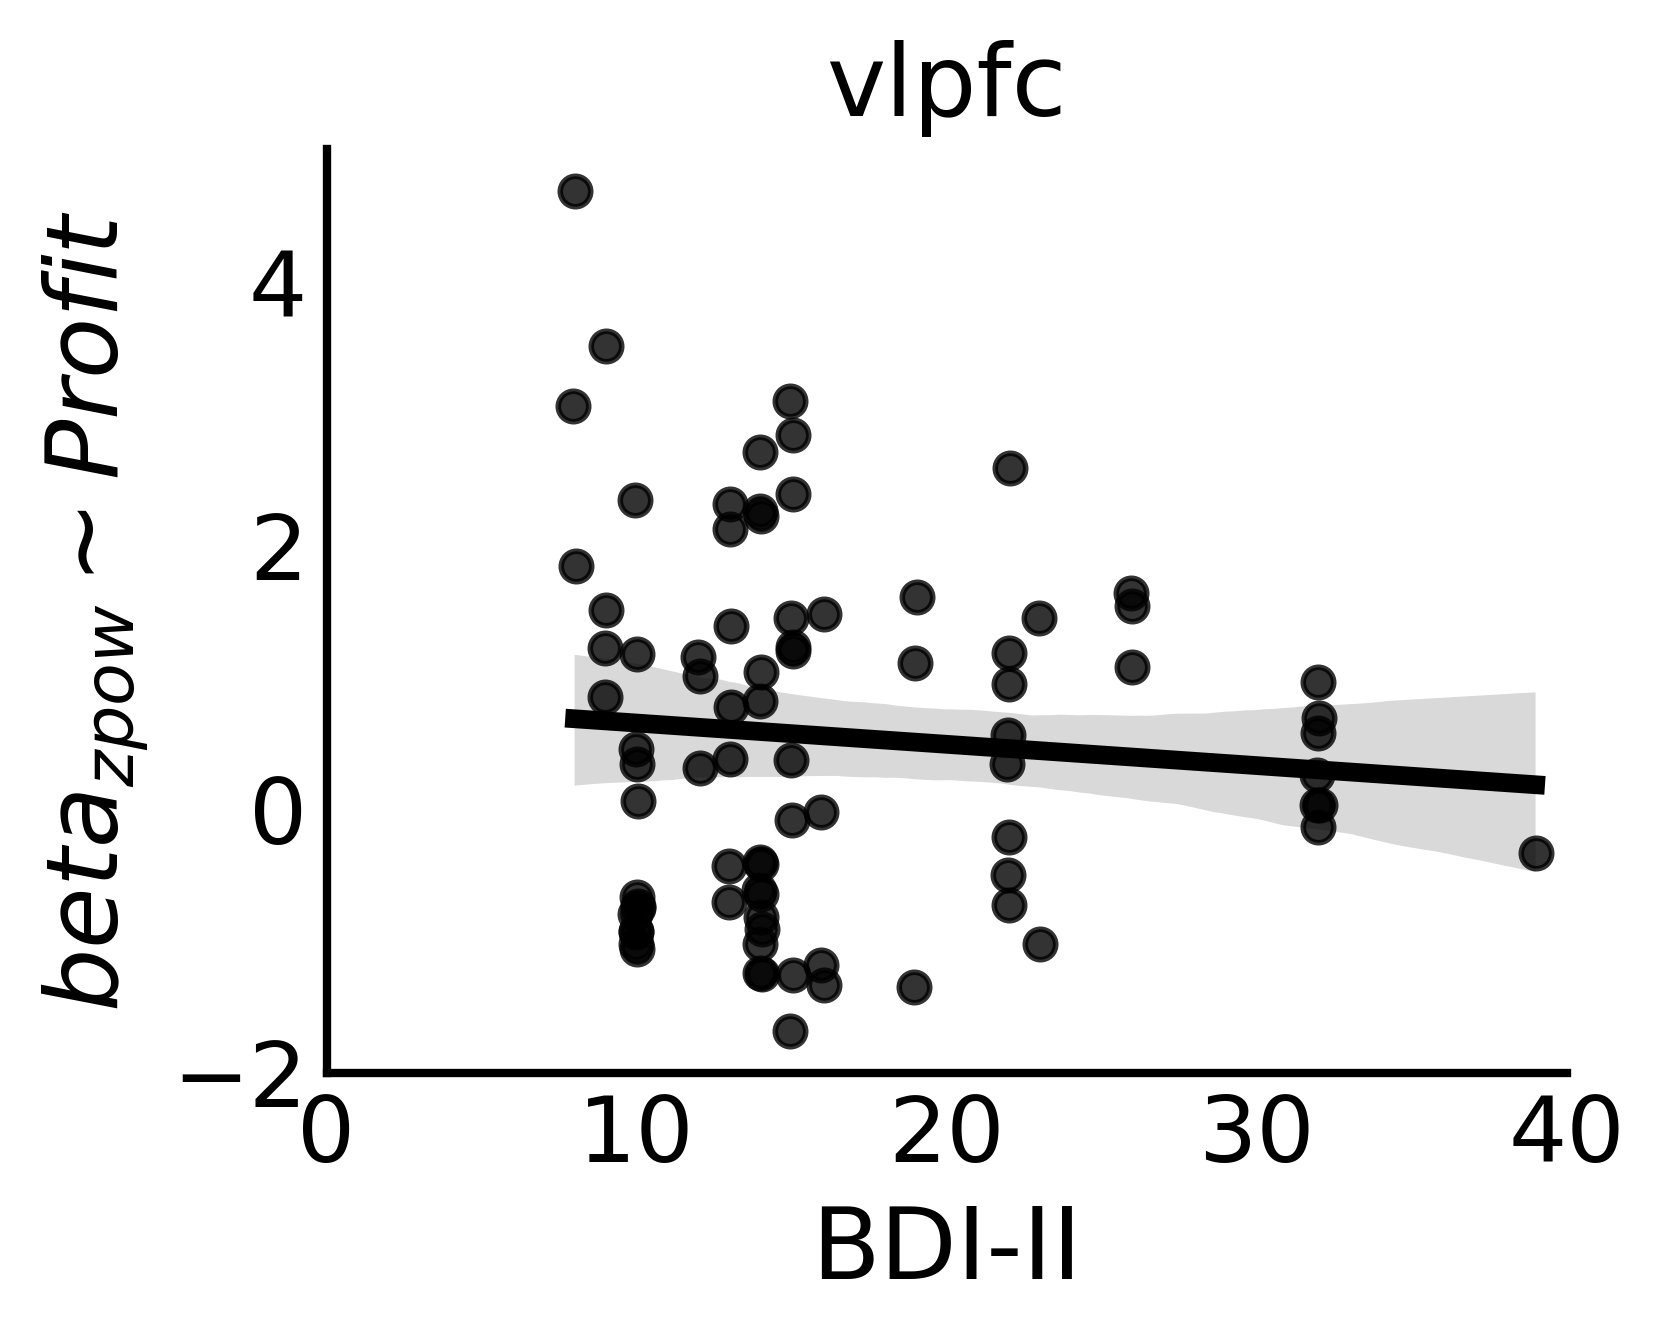

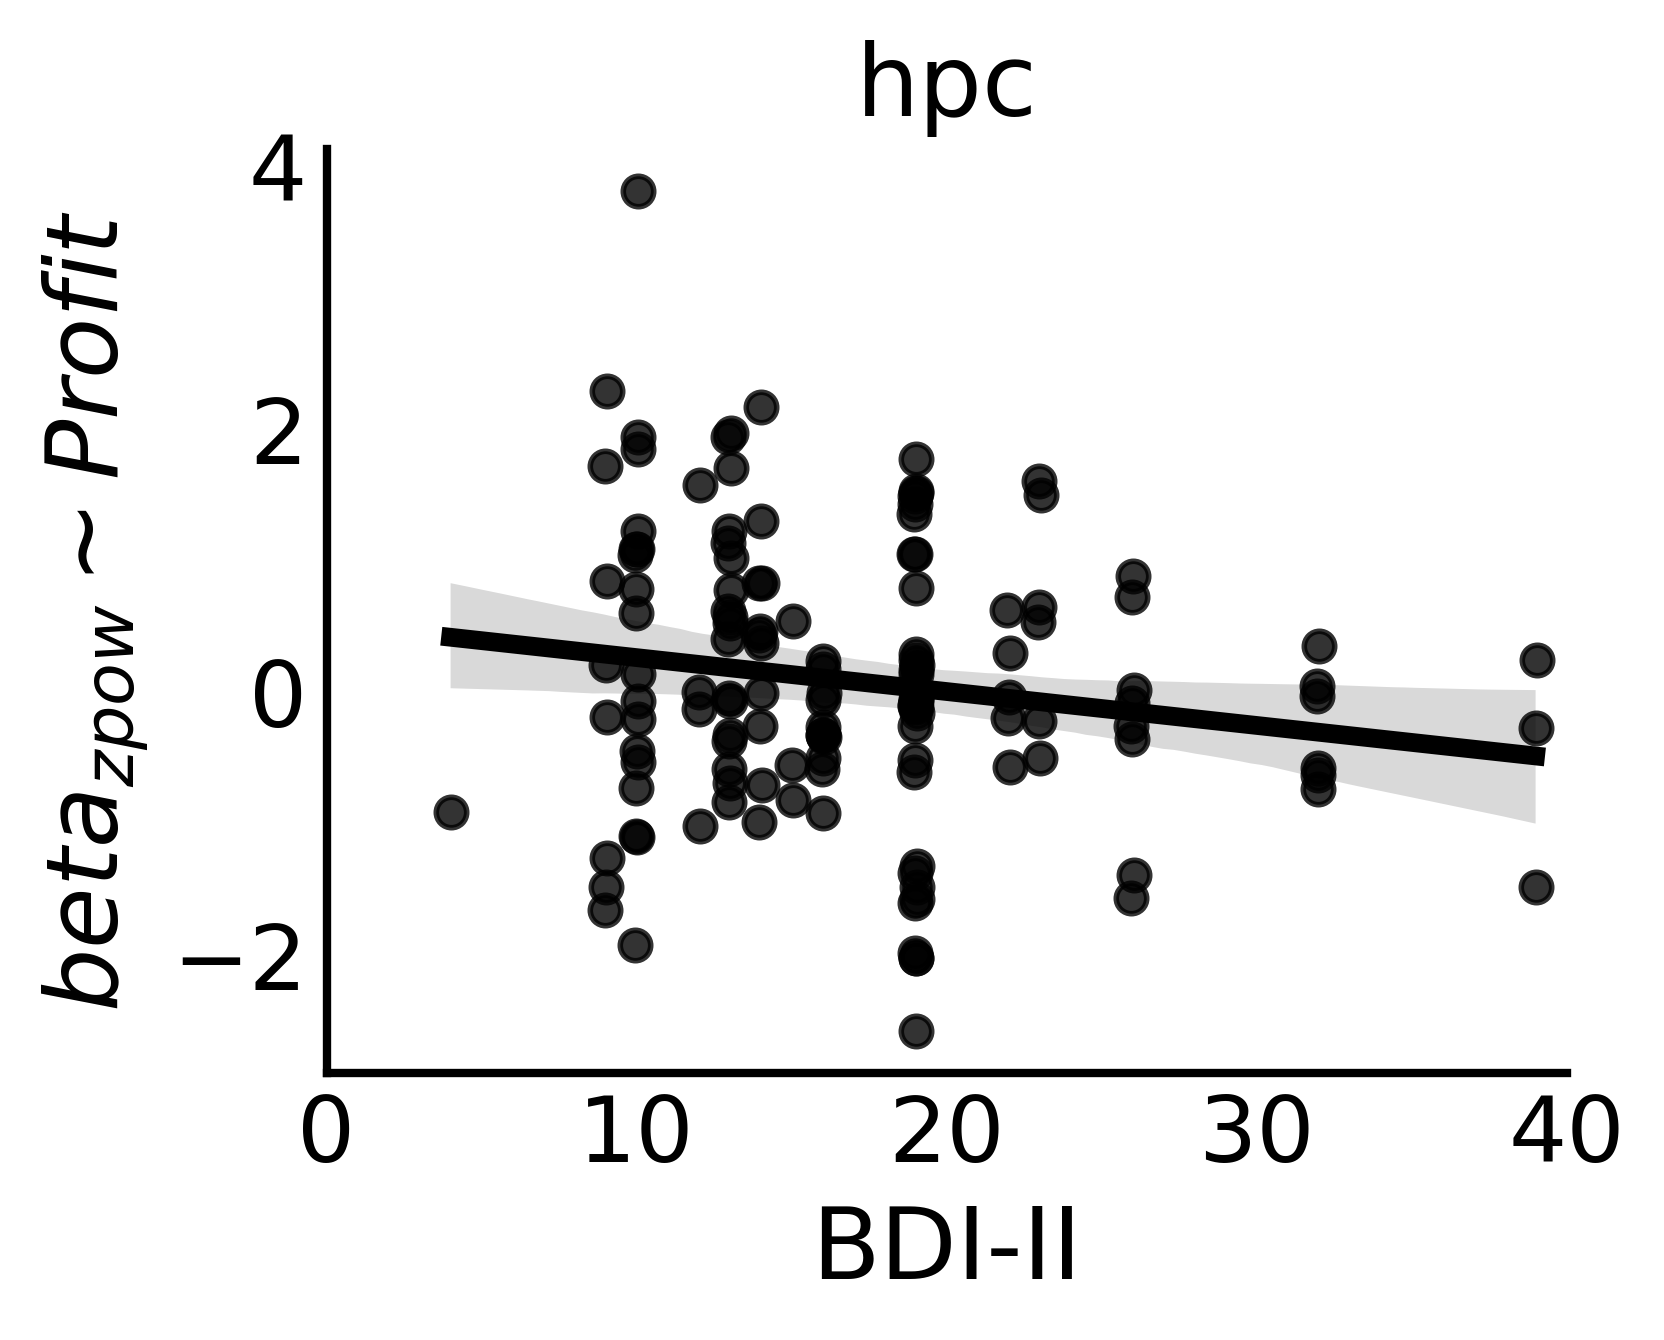

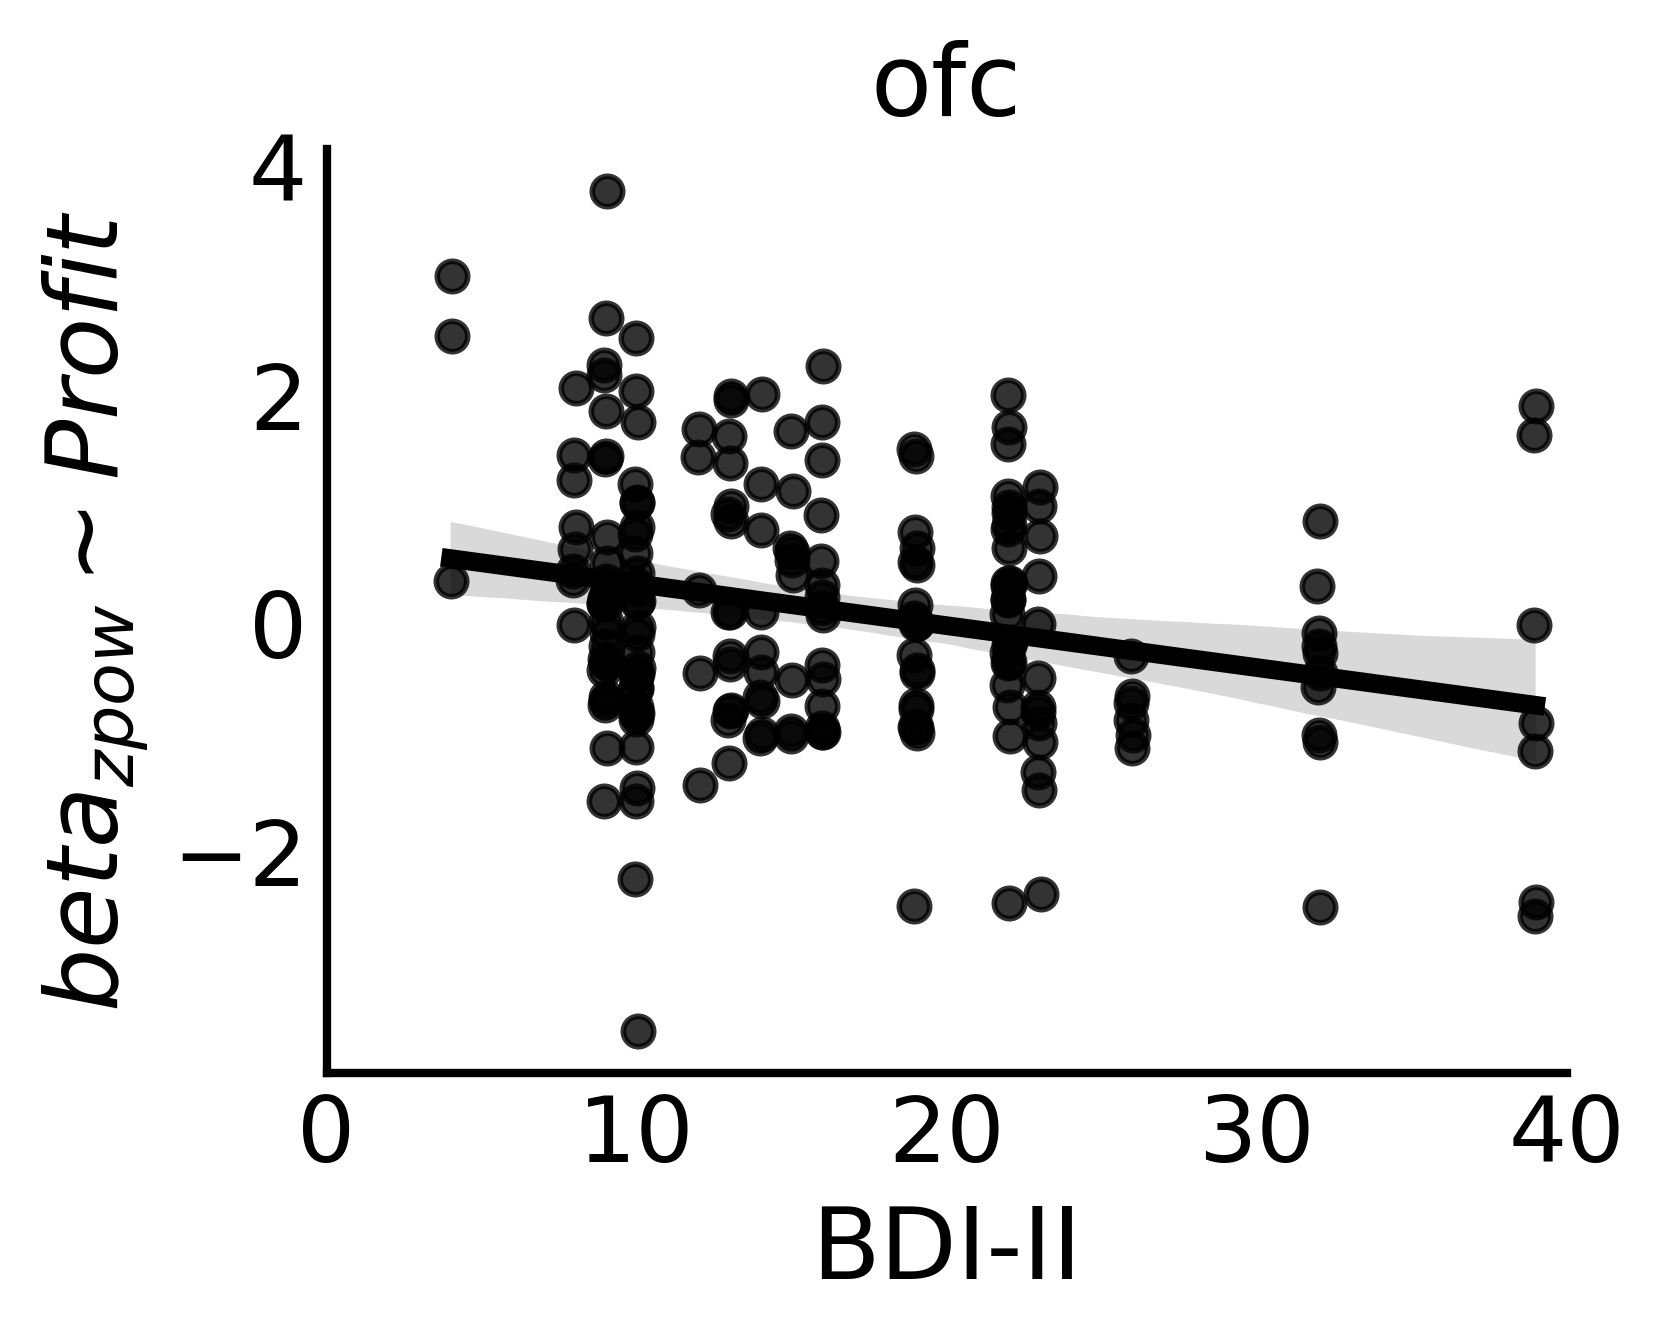

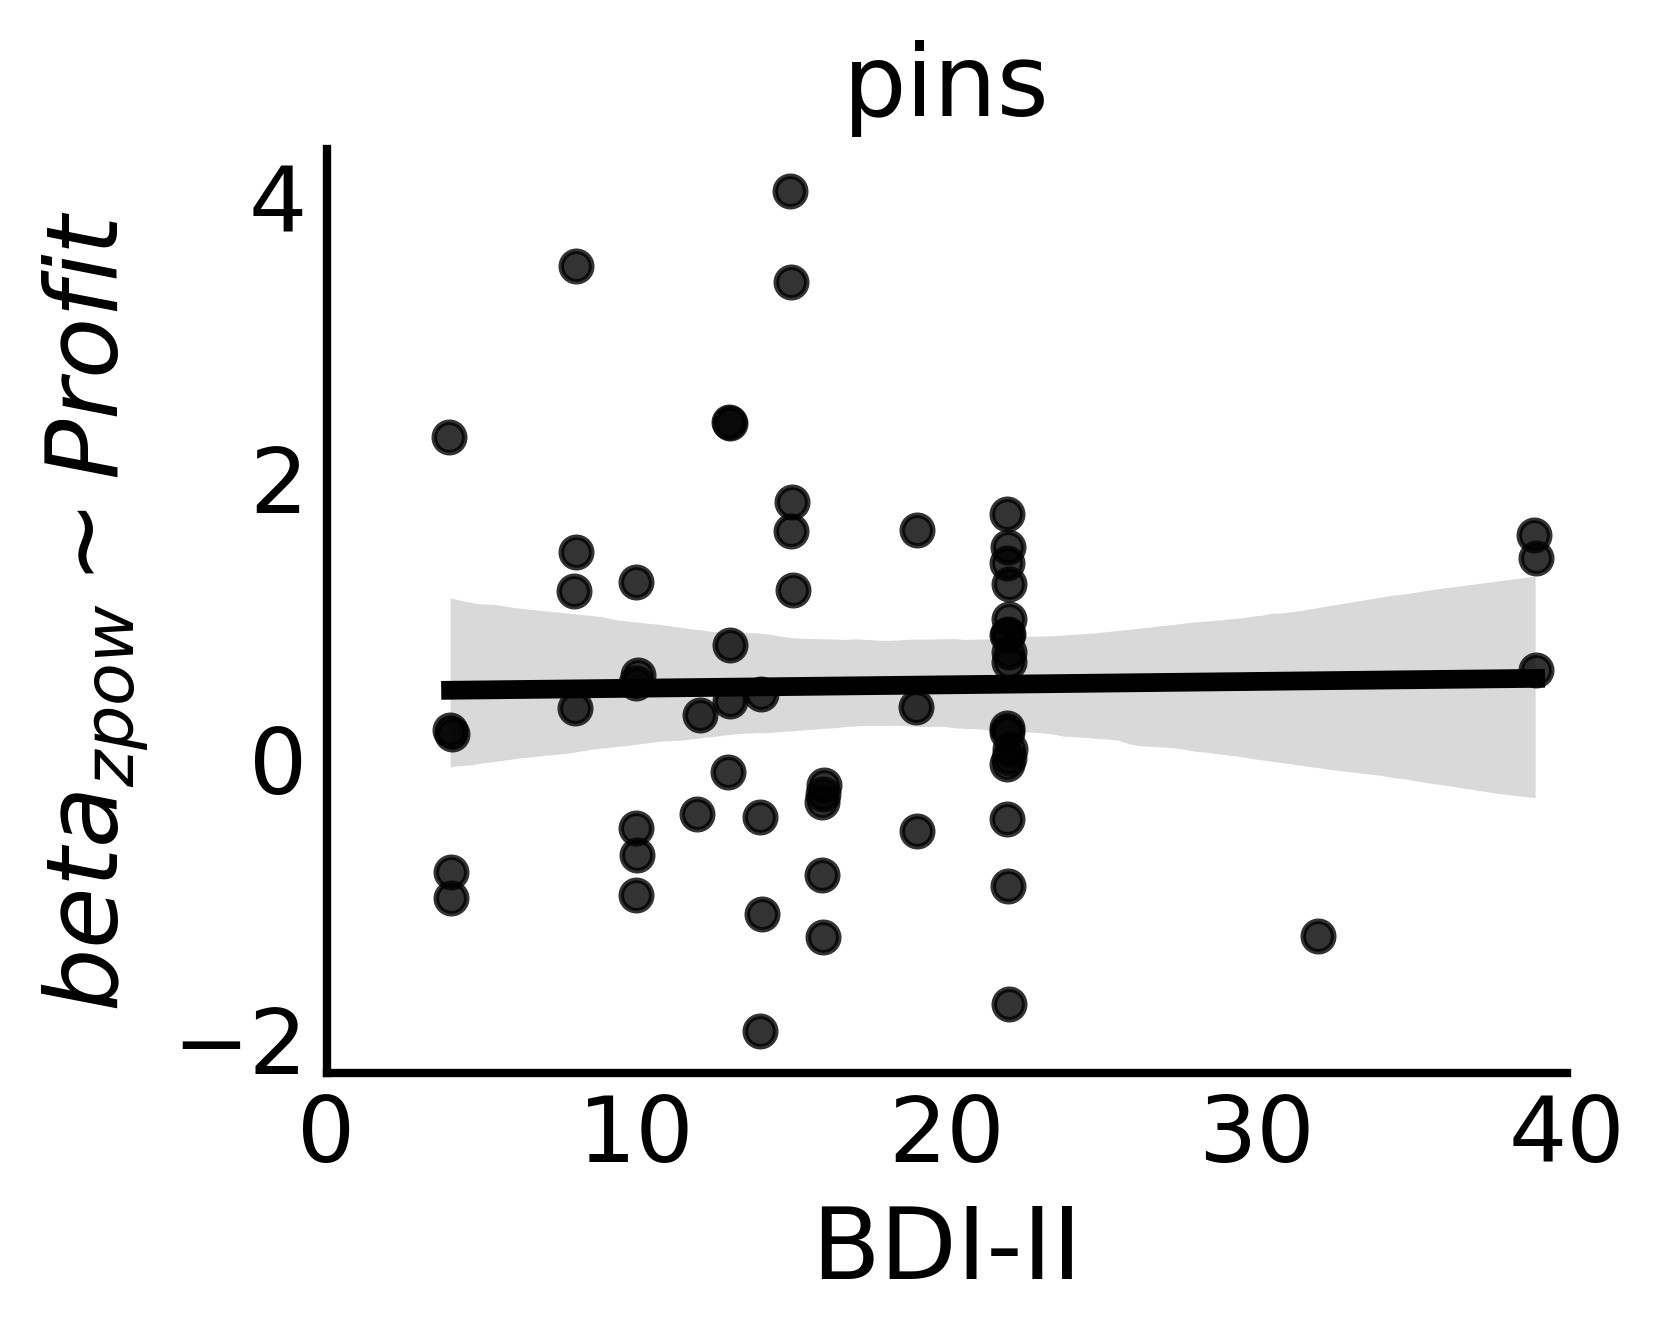

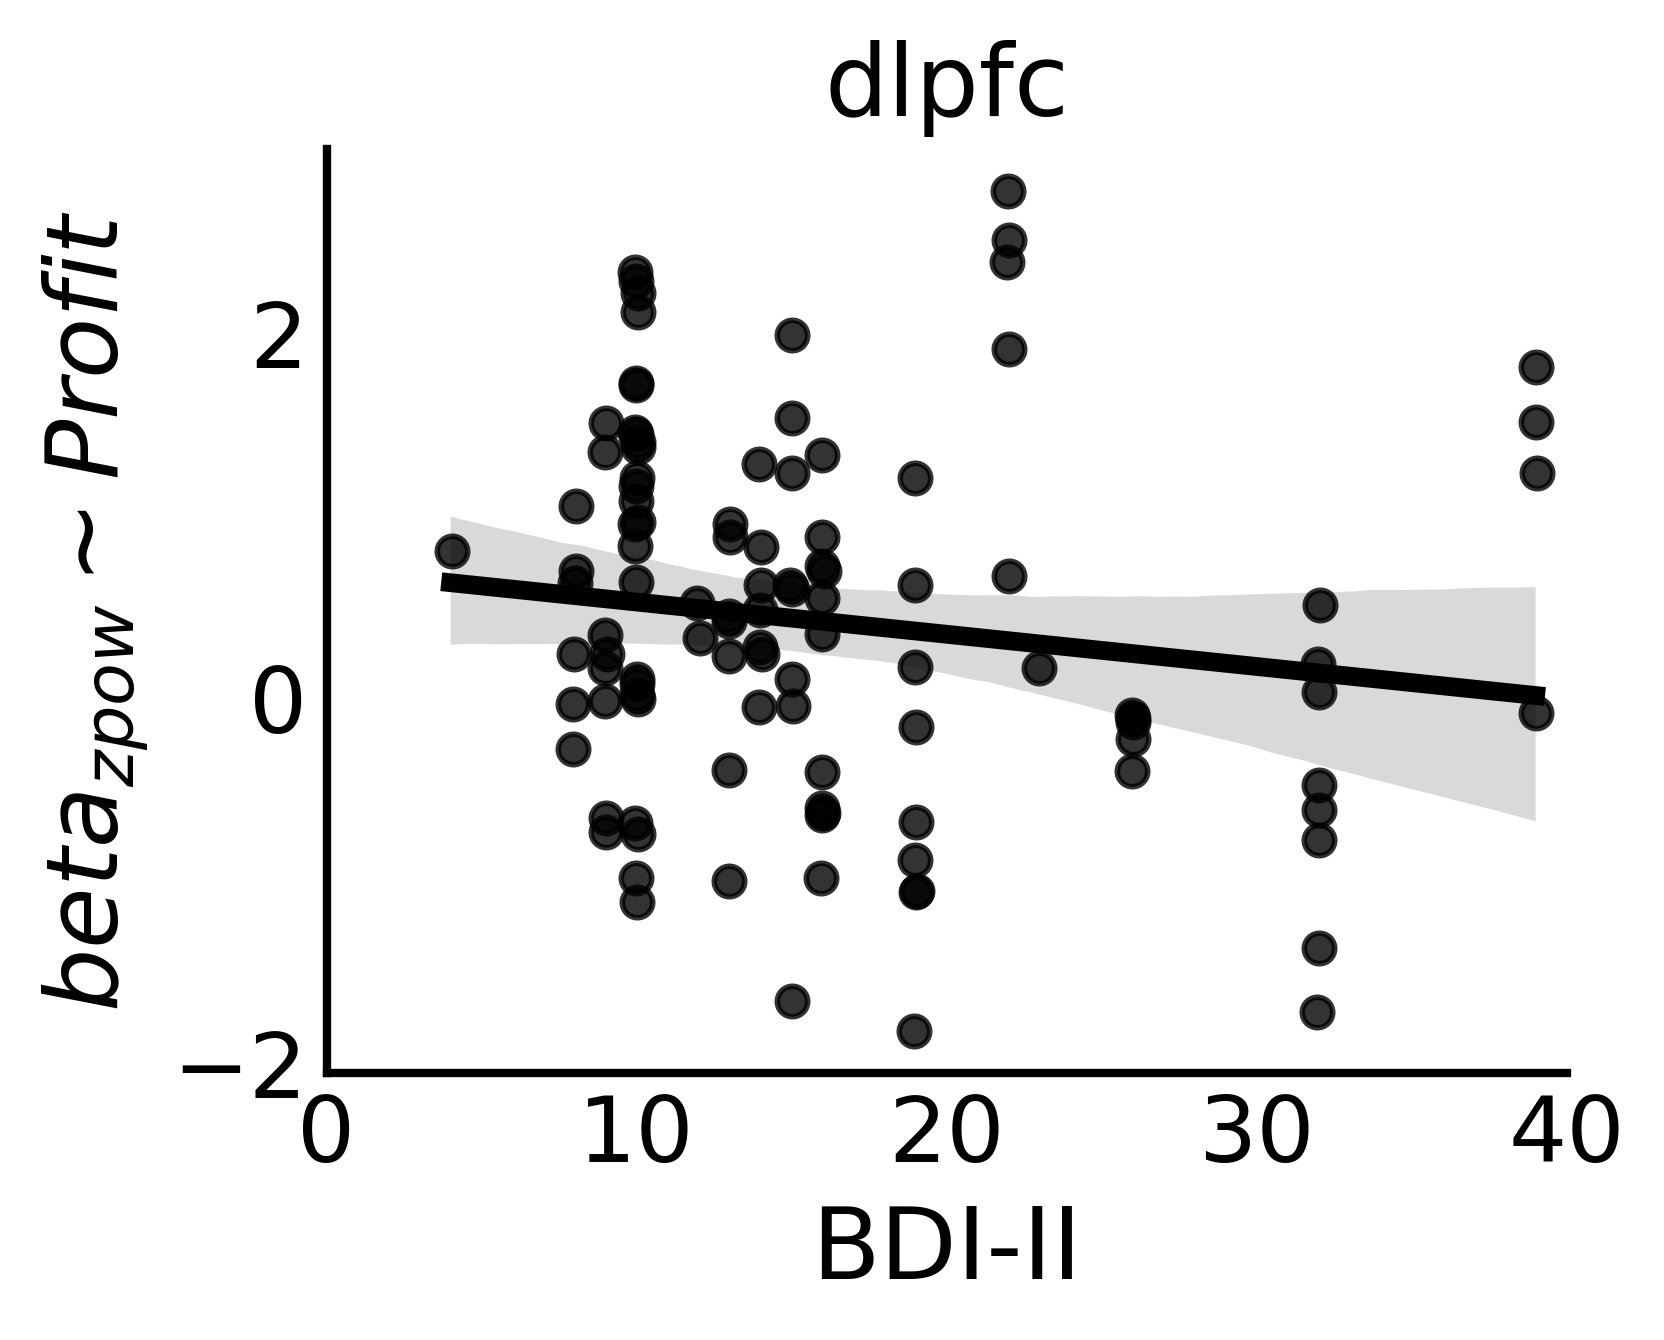

In [58]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_{main_var}_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [59]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 30 Sep 2024                                         
Time:                        19:57:23                                         
No. Iterations:                    16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1720      0.440     36.774     